In [1]:
%matplotlib notebook
import os
import numpy as np
import chaospy as cp
import pandas as pd
import seaborn as sns
import itertools
import scipy.stats as ss  
from numpy import linalg as LA
from matplotlib import pyplot as plt,cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel,WhiteKernel)
pltlinestyles = [ (0, (1, 5)),(0, (3, 5, 1, 5)),(0, (5, 5)),(0, ()), (0, (3, 1, 1, 1, 1, 1)), 
        (0, (5, 10)), (0, (3, 10, 1, 10)), (0, (3, 10, 1, 10, 1, 10)),(0, (1, 10)), 
        (0, (5, 1)),  (0, (3, 1, 1, 1)),(0, (3, 5, 1, 5, 1, 5)),  (0, (1, 1))  ]*10

pltmarkers   =['o','v','s','d','+','*']
ordinal      = lambda n: "%d%s" % (n,"tsnrhtdd"[(math.floor(n/10)%10!=1)*(n%10<4)*n%10::4])
pltcolors    = plt.rcParams['axes.prop_cycle'].by_key()['color']
figsize      = (4*1.5,3*1.5)
pltlinewidth = 1.0

In [2]:
prob_fails      = 1e-4
MODEL_NAME      = 'linear_oscillator'
WORKING_DIR     = os.getcwd()
MODEL_DIR       = os.path.join('/Users/jinsongliu/BoxSync/MUSELab/museuq/examples', MODEL_NAME)
MODEL_DIR_FIGURE= os.path.join(MODEL_DIR,r'Figures')
MODEL_DIR_DATA  = os.path.join('/Users/jinsongliu/External/MUSE_UQ_DATA',MODEL_NAME,r'Data') 

print('WORKING_DIR: {}'.format(WORKING_DIR))
print('+-- MODEL: {}'.format(MODEL_DIR))
print('|   +-- {:<6s}: {}'.format('FIGURE',MODEL_DIR_FIGURE))
print('|   +-- {:<6s}: {}'.format('DATA',MODEL_DIR_DATA))


WORKING_DIR: /Users/jinsongliu/BoxSync/MUSELab/museuq/examples/JupyterNotebook
+-- MODEL: /Users/jinsongliu/BoxSync/MUSELab/museuq/examples/linear_oscillator
|   +-- FIGURE: /Users/jinsongliu/BoxSync/MUSELab/museuq/examples/linear_oscillator/Figures
|   +-- DATA  : /Users/jinsongliu/External/MUSE_UQ_DATA/linear_oscillator/Data


In [3]:
mu_Hs    = 0.77
sigma_Hs = 0.6565
Hs_shape = 1.503
Hs_scale = 2.691
h0       = 2.9
cdf_h0   = 0.6732524353557928
gamma    = 1.503
rho      = 2.691
zeta     = 0.6565

a1 = 1/(np.sqrt(2*np.pi)*0.6565*2.9) * np.exp(-(np.log(2.9)-0.77)**2/(2*0.6565**2))

a2 = (gamma/rho) * (2.9/rho)**(gamma-1) * np.exp(-(2.9/rho)**gamma)
print(a1)
print(a2)

0.18945993853083995
0.18941583365529419


(2, 2002)


<IPython.core.display.Javascript object>


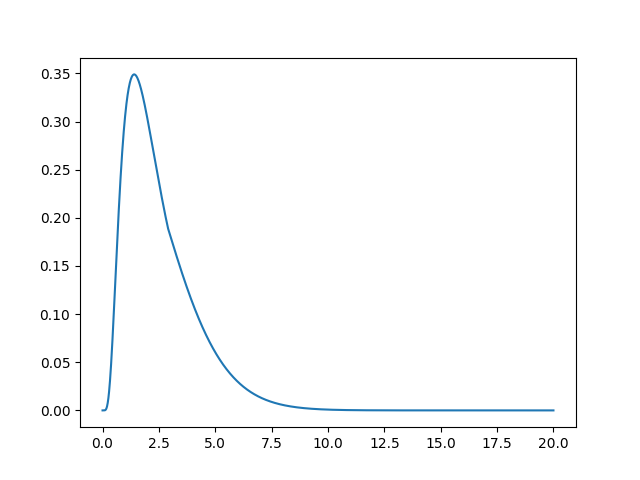

1.0017584199704654

In [4]:
data_set  = np.load('Kvitebjorn_hs.npy')

print(data_set.shape)
plt.figure()
plt.plot(data_set[0,:],data_set[1,:])
sum(data_set[1,:]*0.01)




(4, 100)


(2, 2002)


<IPython.core.display.Javascript object>


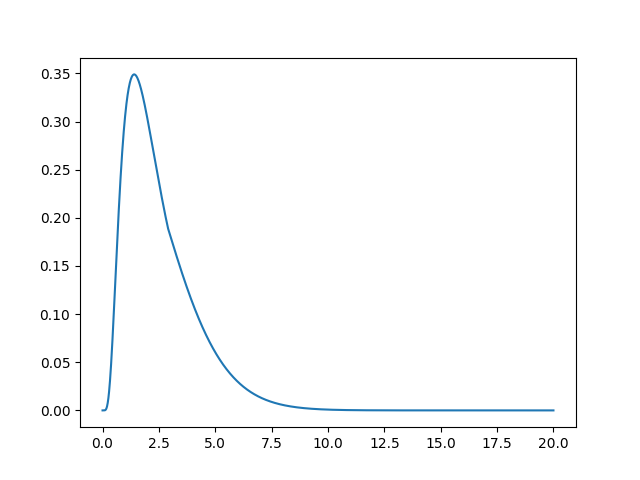

1.0017584199704654

In [31]:
data_set  = np.load('Kvitebjorn_hs.npy')

print(data_set.shape)
plt.figure()
plt.plot(data_set[0,:],data_set[1,:])
sum(data_set[1,:]*0.01)

In [15]:
def make_circle(r,n=100):
    t = np.linspace(0, np.pi * 2.0, n)
    t = t.reshape((len(t), 1))
    x = r * np.cos(t)
    y = r * np.sin(t)
    return np.hstack((x, y))


(4, 100)


<IPython.core.display.Javascript object>


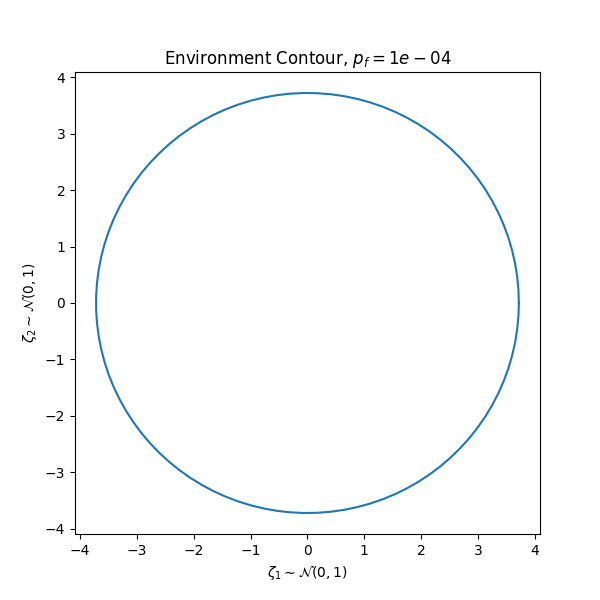

<IPython.core.display.Javascript object>


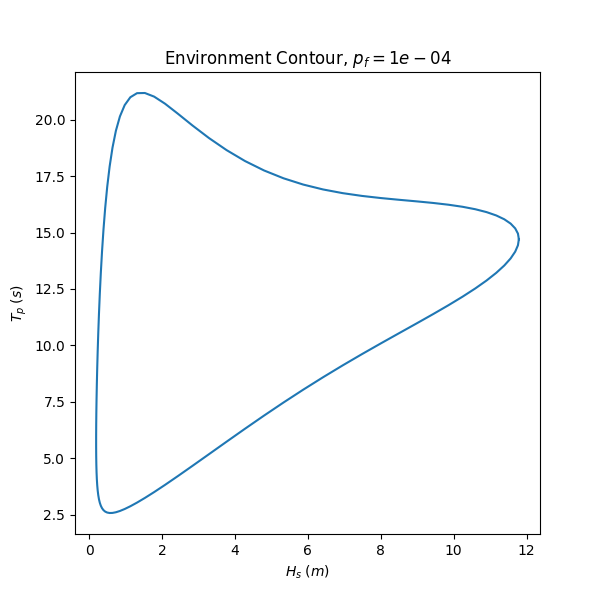

(2, 100)


In [16]:
data_set  = np.load('Kvitebjorn_samples_EC.npy')
print(data_set.shape)
EC_zeta = data_set[:2,:]
EC_x = data_set[2:,:]

# beta = ss.norm.ppf(prob_fails)
# print('{:<20s}:{:.4f}'.format('Reliability Index', beta))
# EC_zeta = make_circle(beta,50)
fig_ec, axs_ec= plt.subplots(figsize=(4*1.5,4*1.5))
axs_ec.plot(EC_zeta[0,:],EC_zeta[1,:])
axs_ec.set_xlabel('$\zeta_1\sim \mathcal{N}(0,1)$')
axs_ec.set_ylabel('$\zeta_2\sim \mathcal{N}(0,1)$')
axs_ec.set_title('Environment Contour, $p_f={:.0e}$'.format(prob_fails));

fig_ec, axs_ec= plt.subplots(figsize=(4*1.5,4*1.5))
axs_ec.plot(EC_x[0,:],EC_x[1,:])
axs_ec.set_xlabel('$H_s \;(m)$')
axs_ec.set_ylabel('$T_p \;(s)$')
axs_ec.set_title('Environment Contour, $p_f={:.0e}$'.format(prob_fails));
# axs_ec.set_aspect('equal', 'box')
# axs_ec.set_aspect('equal', 'box')

print(EC_x.shape)
np.save(os.path.join(MODEL_DIR_DATA,'EC_pfe4'),EC_x)

#  Single Degree of Freedom Oscillator 
\begin{equation}
    m \ddot(x) + c \dot(x) + kx = f
\end{equation}
where,

$m = 100, c = 0.3, k = 2.25 \Rightarrow \omega_n = \sqrt{\frac{k}{m}} = 0.15Hz, \zeta = \frac{c}{2\sqrt{mk}} = 1\%$

$f$: External excitation force. Assuming Gaussian wave from JONSWAP($H_s, T_p$)

$(H_s, T_p) := \boldsymbol{X} \overset{i.i.d}{\sim} $

$(\zeta_1, \zeta_2) := \boldsymbol{\zeta} \overset{i.i.d}{\sim} \mathcal{N}(0,1)$


In [25]:
zeta    = 0.01
omega_n = 2 # rad/s
m       = 1 
k       = (omega_n/2/np.pi) **2 * m 
c       = zeta * 2 * np.sqrt(m * k)
mck     = (m,c,k)
print(m,c,k)

1 0.006366197723675814 0.10132118364233779


In [88]:
data_set = np.load('DoE_McRE3R0_y.npy')
print(data_set.shape)

(1000, 6, 2)


<IPython.core.display.Javascript object>


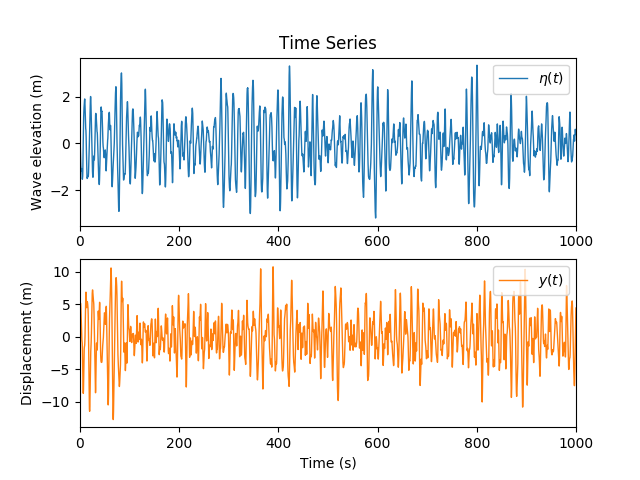

<IPython.core.display.Javascript object>


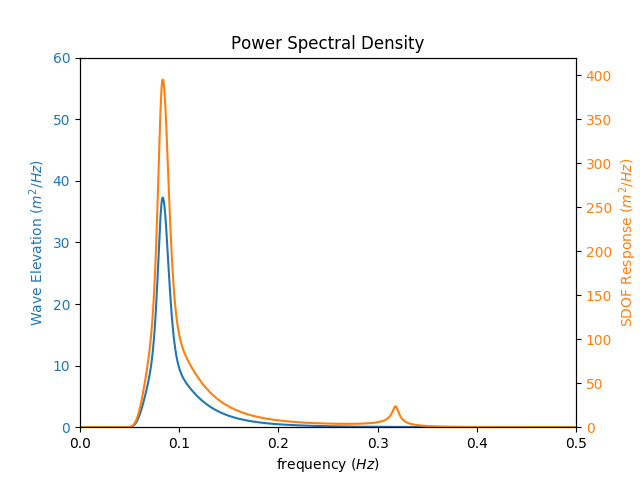

Text(0.5, 1.0, 'Power Spectral Density')

In [25]:
data_set  = np.load('test_linear_oscillator_y.npy')
sdof_time = data_set[:,:3]
sdof_freq = data_set[:,3:]
fig1, axs = plt.subplots(2,1)
axs[0].plot(sdof_time[:,0],sdof_time[:,1], label=r'$\eta(t)$',color=pltcolors[0],linewidth=pltlinewidth);
axs[1].plot(sdof_time[:,0],sdof_time[:,2], label=r'$y(t)$',color=pltcolors[1],linewidth=pltlinewidth);
axs[0].set_xlim(0,1000)
axs[0].set_ylabel('Wave elevation (m)')
axs[0].set_title('Time Series')
axs[0].legend(loc=1)

axs[1].set_xlim(0,1000)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Displacement (m)')
axs[1].legend(loc=1)


fig2, ax2 = plt.subplots()
ax2.plot(sdof_freq[:,0],sdof_freq[:,1],color=pltcolors[0]);
ax2.set_ylabel('Wave Elevation $(m^2/Hz)$',color=pltcolors[0])
ax2.tick_params(axis='y', labelcolor=pltcolors[0])
ax2.set_ylim(0,60)

ax3 = ax2.twinx()  # instantiate a second axes that shares the same x-axis
ax3.plot(sdof_freq[:,0],sdof_freq[:,2],color=pltcolors[1]);
ax3.set_ylabel('SDOF Response $(m^2/Hz)$',color=pltcolors[1])  # we already handled the x-label with ax1
ax3.tick_params(axis='y', labelcolor=pltcolors[1])
ax3.set_ylim(0,420)
# ax2.tick_params(axis='y', labelcolor=color)


ax2.set_xlim(0,0.5)
ax2.set_xlabel(r'frequency ($Hz$)')
ax2.set_title('Power Spectral Density')
# ax2.legend(['JONSWAP($H_s={},T_p={}$)'.format(4, 12), 'PSD($y(t)$)'])

# 1. Design of Experiment

<IPython.core.display.Javascript object>


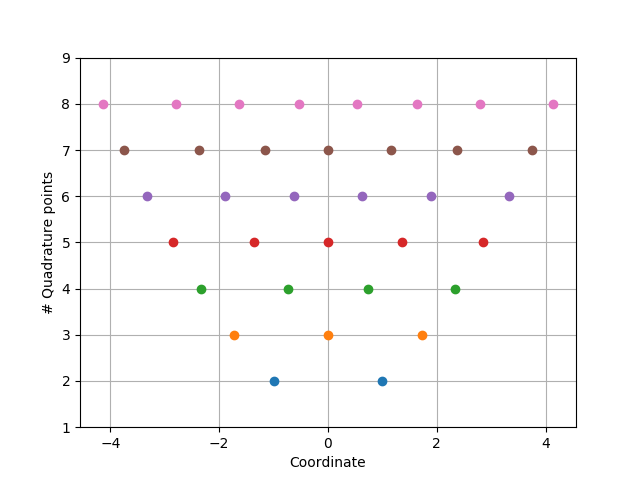

In [26]:
plt.figure()
for iorder in range(2,9):
    coord1d_e, weight1d_e = np.polynomial.hermite_e.hermegauss(iorder)
    plt.plot(coord1d_e, iorder/10*np.ones(coord1d_e.shape),'o');
locs, labels = plt.yticks()            # Get locations and labels
plt.yticks(locs, [str(int(i*10)) for i in locs]);
plt.grid()
plt.xlabel('Coordinate')
plt.ylabel('# Quadrature points')
plt.savefig('Quadrature_points.png')


In [96]:
ec_top_eta = []
ec_top_y   = []
for P in [1,5,10]:
    ec_in_filename = '/Users/jinsongliu/BoxSync/MUSELab/museuq/museuq/environment/Kvitebjørn_EC_P{:d}.npy'.format(P)
    data_set= np.load(ec_in_filename)
    ec_x    = data_set[2:,:]
    print(ec_x.shape)
    ec_out_filename = 'Kvitebjørn_EC_P{:d}_25.npy'.format(P)
    ec_data = np.squeeze(np.load(os.path.join(MODEL_DIR_DATA, ec_out_filename)))
    ec_eta  = np.squeeze(ec_data[:,:,4,0])
    ec_y    = np.squeeze(ec_data[:,:,4,1])
    ec_eta_median = np.median(ec_eta,axis=0)
    ec_y_median   = np.median(ec_y,axis=0)
    
    sorted_idx = np.argsort(-ec_eta_median)
    print(sorted_idx.shape)
    ec_top_eta.append(np.vstack((ec_x[:,sorted_idx], ec_eta_median[sorted_idx])))

    sorted_idx = np.argsort(-ec_y_median)
    ec_top_y.append(np.vstack((ec_x[:,sorted_idx], ec_y_median[sorted_idx])))
print(np.array(ec_top_eta).shape)
print(ec_top_y)

(2, 100)
(100,)
(2, 100)
(100,)
(2, 100)
(100,)
(3, 3, 100)
[array([[12.49917549, 12.72059056, 12.06372813, 12.72059056, 12.63727033,
        11.77002917, 12.74844133, 12.30745959, 12.74844133, 12.49917549,
        12.30745959, 12.63727033, 11.77002917, 11.42884142, 12.06372813,
        10.15127384, 11.04305985, 11.04305985, 10.61597896, 11.42884142,
         9.65297897, 10.61597896,  9.12546501, 10.15127384,  8.57341336,
         9.65297897,  8.00178852,  7.41580782,  9.12546501,  6.22270763,
         6.820908  ,  8.57341336,  5.62696383,  8.00178852,  7.41580782,
         5.03952086,  6.820908  ,  4.46624739,  3.91295761,  6.22270763,
         2.88940892,  3.38531063,  5.62696383,  1.75399521,  2.44720408,
         2.07163322,  5.03952086,  4.46624739,  1.48630473,  3.91295761,
         3.38531063,  2.88940892,  1.26136518,  2.44720408,  1.07278898,
         2.07163322,  1.75399521,  0.91497965,  1.48630473,  1.26136518,
         0.78308786,  1.07278898,  0.67295135,  0.91497965,  0.

Data set shape: (5, 25)
Train data shape
Train X   : (2, 25)
Weight    : (25,)


<IPython.core.display.Javascript object>


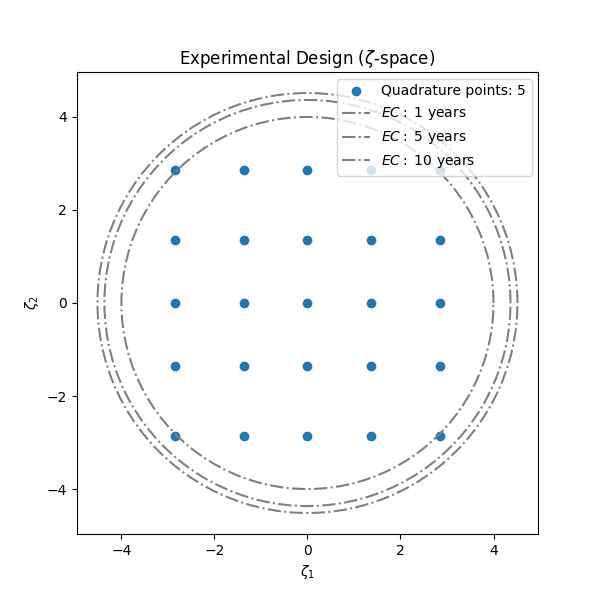

<IPython.core.display.Javascript object>


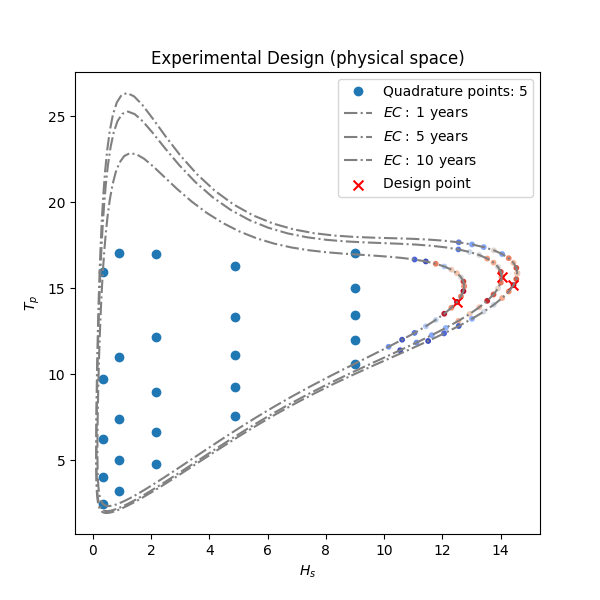

Data set shape: (5, 36)
Train data shape
Train X   : (2, 36)
Weight    : (36,)


<IPython.core.display.Javascript object>


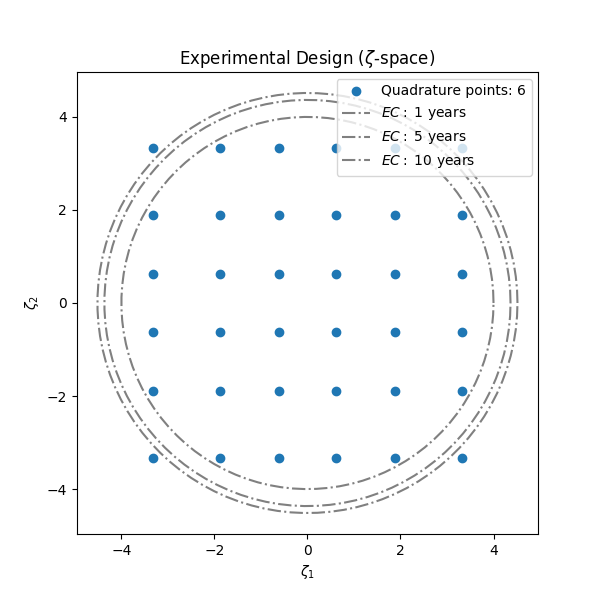

<IPython.core.display.Javascript object>


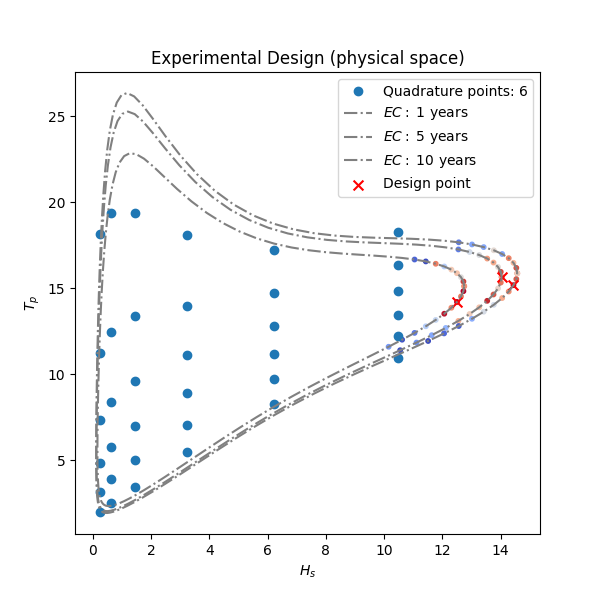

Data set shape: (5, 49)
Train data shape
Train X   : (2, 49)
Weight    : (49,)


<IPython.core.display.Javascript object>


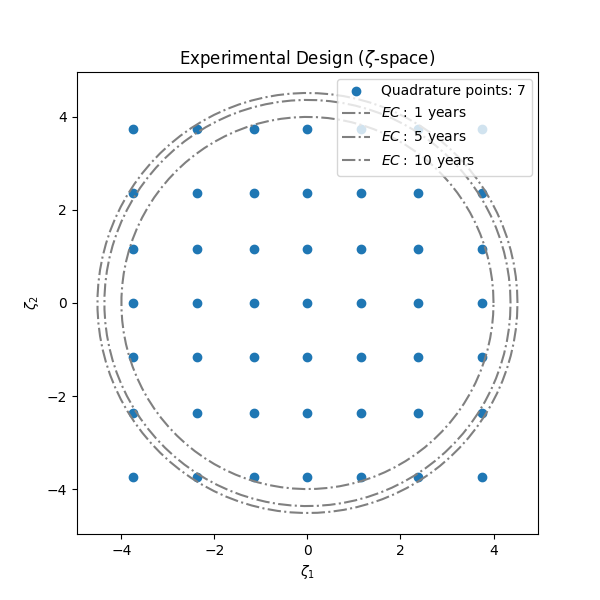

<IPython.core.display.Javascript object>


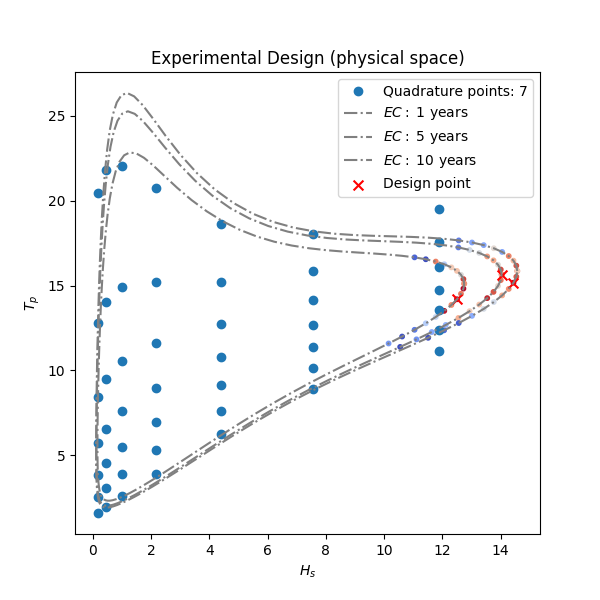

Data set shape: (5, 64)
Train data shape
Train X   : (2, 64)
Weight    : (64,)


<IPython.core.display.Javascript object>


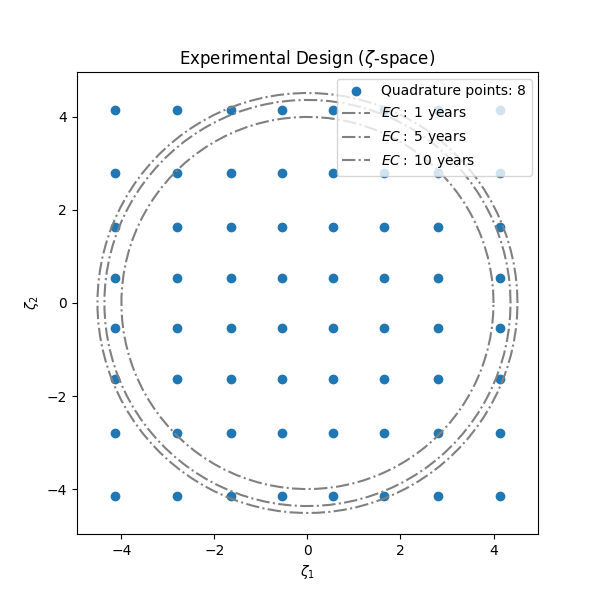

<IPython.core.display.Javascript object>


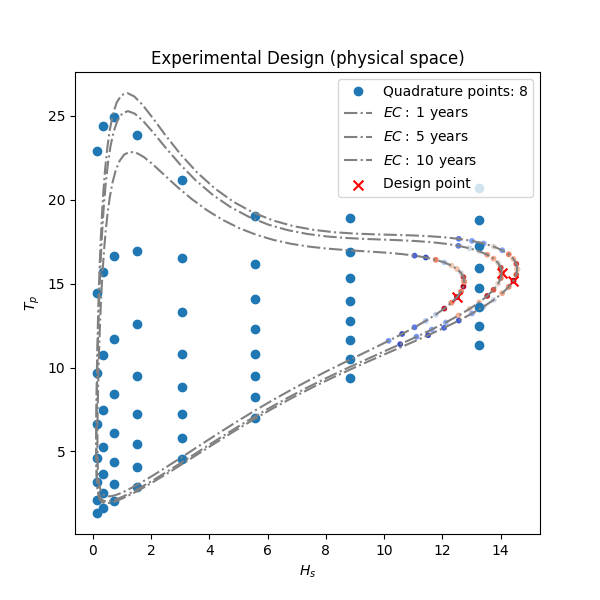

Data set shape: (5, 81)
Train data shape
Train X   : (2, 81)
Weight    : (81,)


<IPython.core.display.Javascript object>


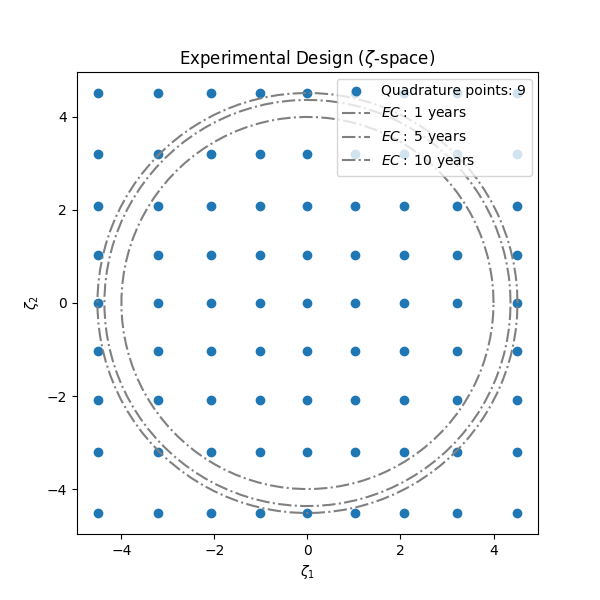

<IPython.core.display.Javascript object>


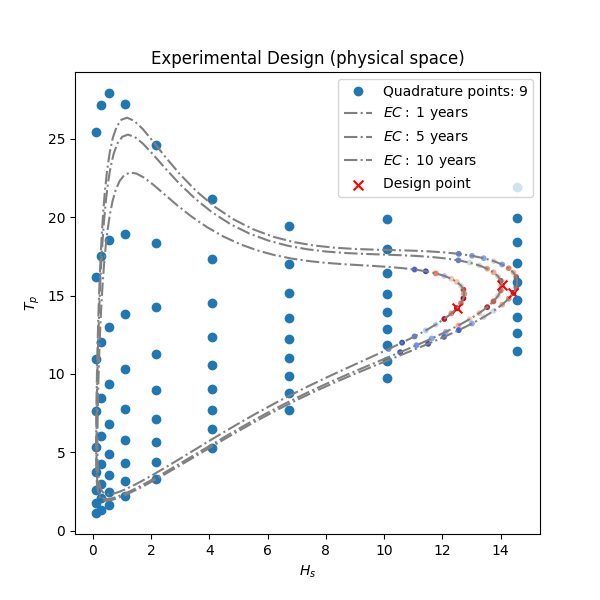

Data set shape: (5, 100)
Train data shape
Train X   : (2, 100)
Weight    : (100,)


<IPython.core.display.Javascript object>


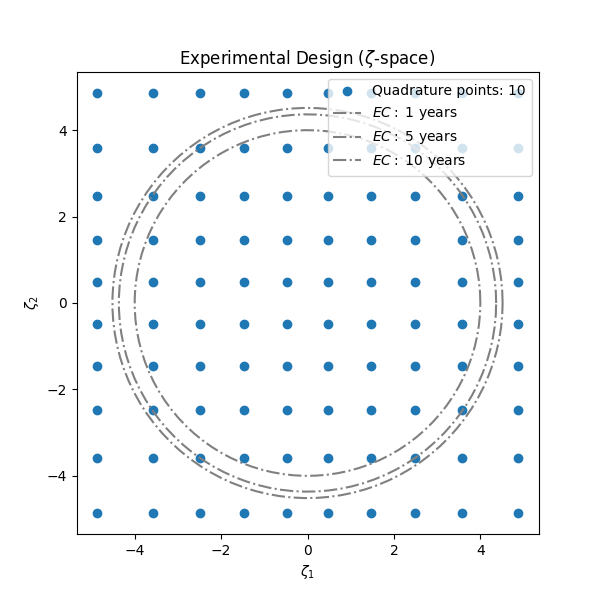

<IPython.core.display.Javascript object>


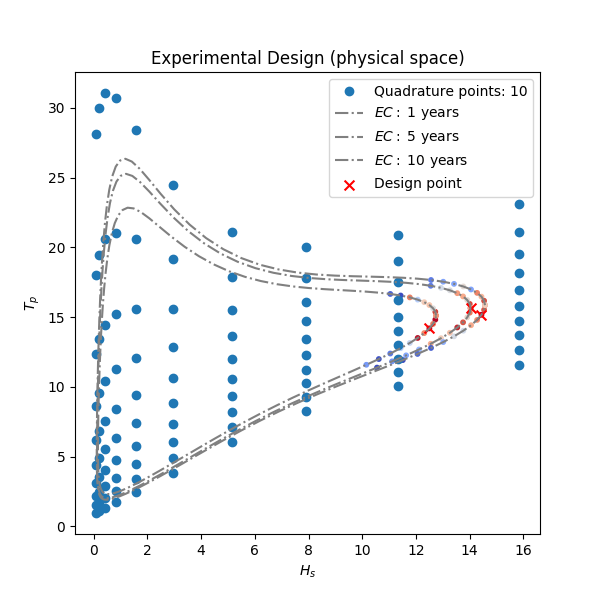

In [111]:
for idoe in np.arange(5,11):
    filename = 'DoE_QuadHem{:d}.npy'.format(idoe)
    data_set = np.load(os.path.join(MODEL_DIR_DATA,filename))
    print('Data set shape: {}'.format(data_set.shape))
    train_zeta= data_set[:2,:]
    train_w  = data_set[2,:]
    train_x  = data_set[3:5,:]
    print('{:<15s}'.format('Train data shape'))
    print('{:<10s}: {}'.format('Train X', train_x.shape))
#     print('{:<10s}: \n{}'.format('Train X', np.around(train_x.T,2)))    
#     print('{:<10s}: \n{}'.format('Train zeta', np.around(train_zeta.T,2)))
    # print('{:<15s}: {}'.format('Y', train_y.shape))
    print('{:<10s}: {}'.format('Weight', train_w.shape))

    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(train_zeta[0,:],train_zeta[1,:],'o',label='Quadrature points: {:d}'.format(idoe));
    for iT, T in enumerate([1,5,10]):
        data_set = np.load('/Users/jinsongliu/BoxSync/MUSELab/museuq/museuq/environment/Kvitebjørn_EC_P{:d}.npy'.format(T))
        EC  = data_set[:2,:]
        ax.plot(EC[0,:],EC[1,:],'-.',color='gray', label=r'$EC:$ {:d} years'.format(T))
#         iec_top_eta = ec_top_eta[iT]
#         x = np.squeeze(iec_top_eta[0,:10])
#         y = np.squeeze(iec_top_eta[1,:10])
#         z = np.squeeze(iec_top_eta[2,:10])
#         ax.scatter(x,y, c=z)
    ax.set_xlabel(r'$\zeta_1$')
    ax.set_ylabel(r'$\zeta_2$')
    ax.set_title('Experimental Design ($\zeta$-space)')
#     circle = plt.Circle((0, 0), beta, color='b',alpha=0.4)
#     ax.add_artist(p)
#     ax.add_artist(circle)
#     ax.set_xlim(-4.5,4.5)
#     ax.set_ylim(-4.5,4.5)
    ax.set_aspect('equal', 'box')
    ax.legend(loc='upper right')
    plt.savefig(os.path.join(MODEL_DIR_FIGURE,'DoE_QuadHem{:d}_zeta.pdf'.format(idoe)))
    
 
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(train_x[0,:],train_x[1,:],'o',label='Quadrature points: {:d}'.format(idoe));
    for iT, T in enumerate([1,5,10]):
        data_set = np.load('/Users/jinsongliu/BoxSync/MUSELab/museuq/museuq/environment/Kvitebjørn_EC_P{:d}.npy'.format(T))
        EC  = data_set[2:,:]
        ax.plot(EC[0,:],EC[1,:],'-.',color='gray', label=r'$EC:$ {:d} years'.format(T))
        iec_top_y = ec_top_y[iT]
        x = np.squeeze(iec_top_y[0,:20])
        y = np.squeeze(iec_top_y[1,:20])
        z = np.squeeze(iec_top_y[2,:20])
        ax.scatter(x,y, c=z,s=10,cmap='coolwarm')
        if iT==1:
            ax.scatter(x[0],y[0],s=50,marker='x',c='r',label=r'Design point')
        else:
            ax.scatter(x[0],y[0],s=50,marker='x',c='r')
    ax.set_xlabel(r'$H_s$')
    ax.set_ylabel(r'$T_p$')
    ax.set_title('Experimental Design (physical space)')
#     circle = plt.Circle((0, 0), beta, color='b',alpha=0.4)
#     ax.add_artist(p)
#     ax.add_artist(circle)
#     ax.set_xlim(-4.5,4.5)
#     ax.set_ylim(-4.5,4.5)
#     ax.set_aspect('equal', 'box')
    ax.legend(loc='upper right')
    plt.savefig(os.path.join(MODEL_DIR_FIGURE,'DoE_QuadHem{:d}_env.pdf'.format(idoe)))
    
#     fig1, ax1 = plt.subplots(figsize=(6,6))
#     ax1.plot(train_x[0,:],train_x[1,:],'o');
#     ax1.set_xlabel(r'$x_1$')
#     ax1.set_ylabel(r'$x_2$')
#     # ax1.grid()
#     ax1.set_title('Experimental Design')


# 2. Run DoE (get train data) 

<IPython.core.display.Javascript object>


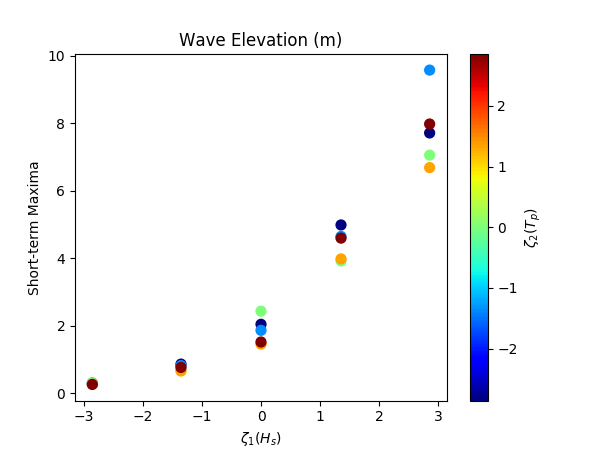

<IPython.core.display.Javascript object>


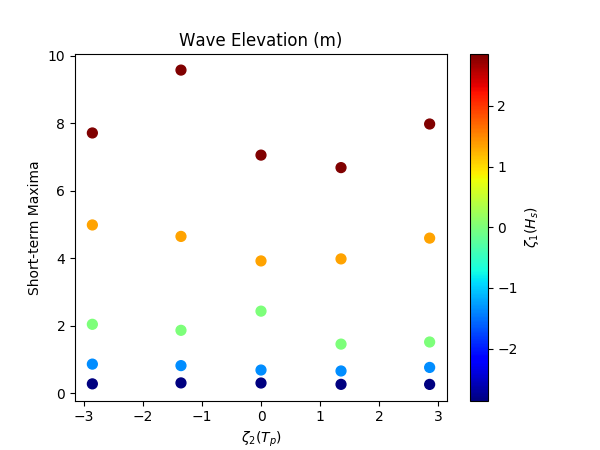

<IPython.core.display.Javascript object>


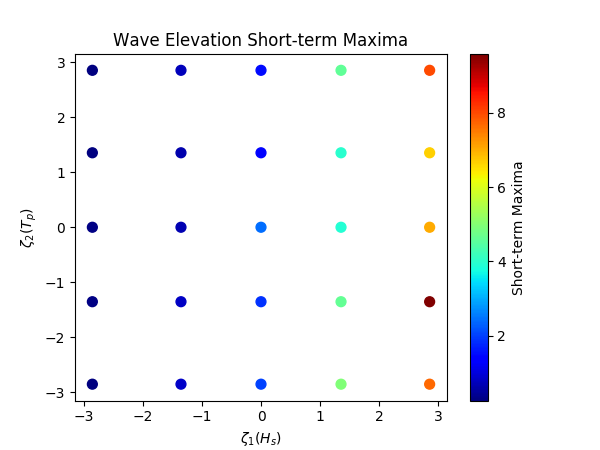

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


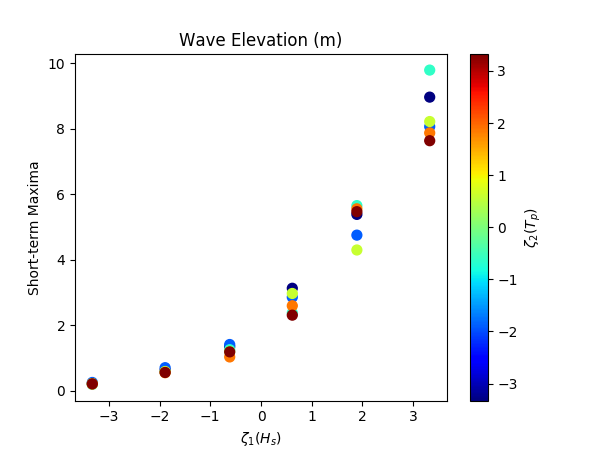

<IPython.core.display.Javascript object>


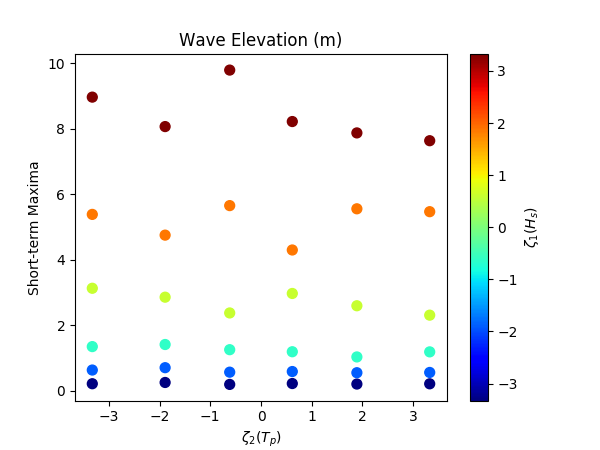

<IPython.core.display.Javascript object>


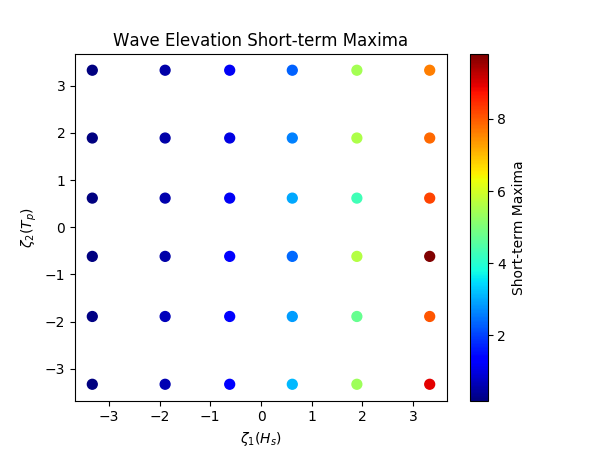

<IPython.core.display.Javascript object>


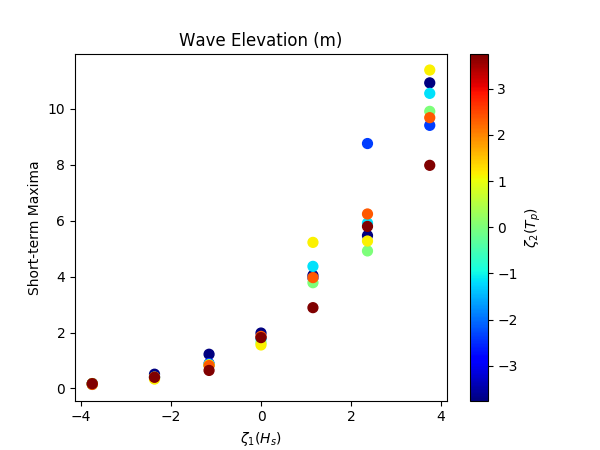

<IPython.core.display.Javascript object>


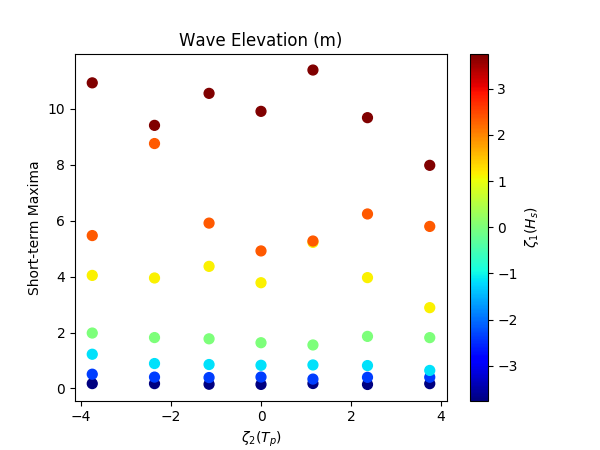

<IPython.core.display.Javascript object>


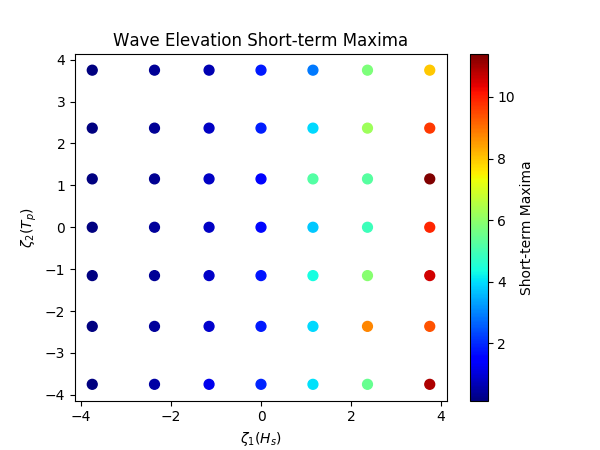

<IPython.core.display.Javascript object>


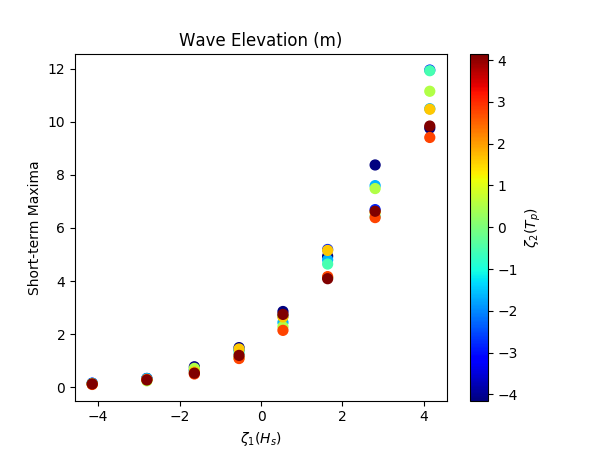

<IPython.core.display.Javascript object>


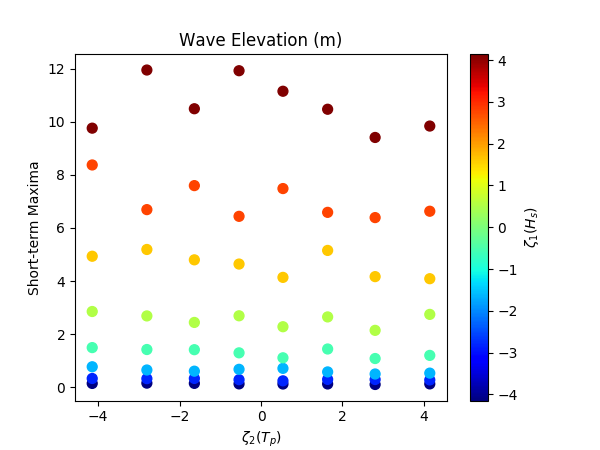

<IPython.core.display.Javascript object>


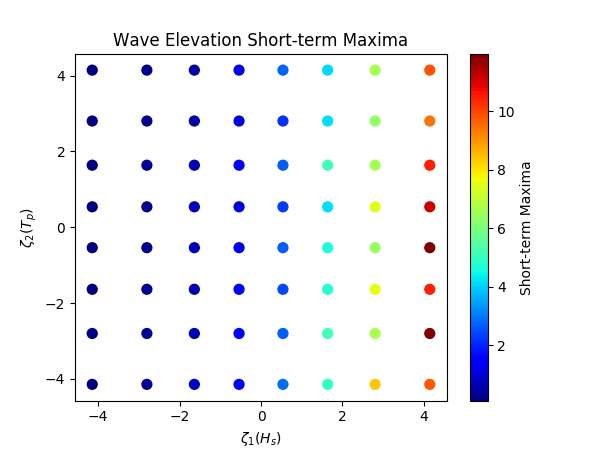

In [36]:
stats2analysis = 4  ##  [mean, std, skewness, kurtosis, absmax, absmin, up_crossing]
qoi2analysis   = 1  ## (t,eta,y,f,eta_pxx, y_pxx)
    
for idoe in np.arange(5,9):
    filename  = 'DoE_QuadHem{:d}.npy'.format(idoe)
    data_set  = np.load(os.path.join(MODEL_DIR_DATA,filename))
    train_zeta= data_set[:2,:]
    train_w   = data_set[2,:]
    train_x   = data_set[3:5,:]
    
    filename  = 'DoE_QuadHem{:d}_stats.npy'.format(idoe)
    data_set  = np.load(os.path.join(MODEL_DIR_DATA,filename))
    train_y   = np.squeeze(data_set[:, stats2analysis, qoi2analysis])
    
    fig       = plt.figure(figsize=figsize)    
    plt.scatter(train_zeta[0,:], train_y, c=train_zeta[1,:],s=50,cmap=cm.jet)
    plt.xlabel(r'$\zeta_1(H_s)$')
    plt.ylabel(r'Short-term Maxima')
    plt.title(r'Wave Elevation (m)')
    corbar = plt.colorbar()    
    corbar.set_label(r'$\zeta_2(T_p)$')
    plt.savefig(os.path.join(MODEL_DIR_FIGURE,'DoE_QuadHem{:d}_Xvs1.pdf'.format(idoe)))

    
    fig = plt.figure(figsize=figsize)    
    plt.scatter(train_zeta[1,:], train_y, c=train_zeta[0,:], s=50,cmap=cm.jet)
    plt.xlabel(r'$\zeta_2(T_p)$')
    plt.ylabel(r'Short-term Maxima')
    plt.title(r'Wave Elevation (m)')
    corbar = plt.colorbar()    
    corbar.set_label(r'$\zeta_1(H_s)$') 
    plt.savefig(os.path.join(MODEL_DIR_FIGURE,'DoE_QuadHem{:d}_Xvs2.pdf'.format(idoe)))
    
    fig = plt.figure(figsize=figsize)    
    plt.scatter(train_zeta[0,:], train_zeta[1,:], c=train_y, s=50,cmap=cm.jet)
    plt.xlabel(r'$\zeta_1(H_s)$')
    plt.ylabel(r'$\zeta_2(T_p)$')
    plt.title(r'Wave Elevation Short-term Maxima')
    corbar = plt.colorbar()    
    corbar.set_label(r'Short-term Maxima')
    plt.savefig(os.path.join(MODEL_DIR_FIGURE,'DoE_QuadHem{:d}_Xvs12.pdf'.format(idoe)))



<IPython.core.display.Javascript object>


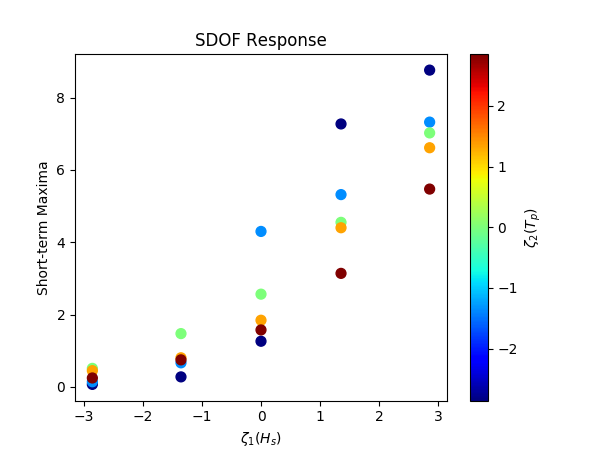

<IPython.core.display.Javascript object>


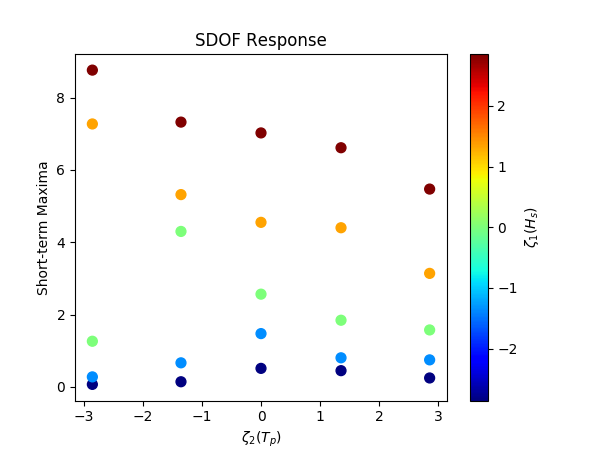

<IPython.core.display.Javascript object>


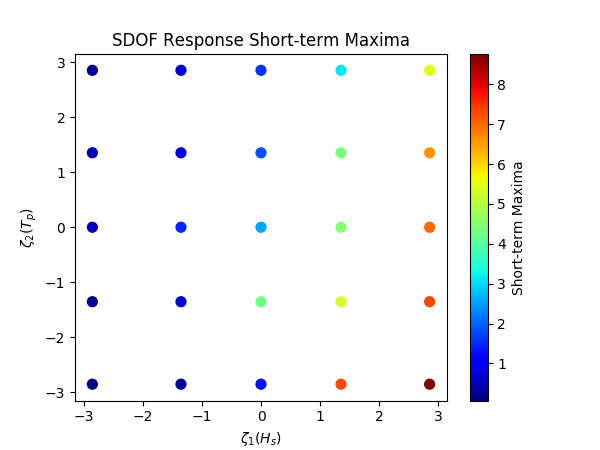

<IPython.core.display.Javascript object>


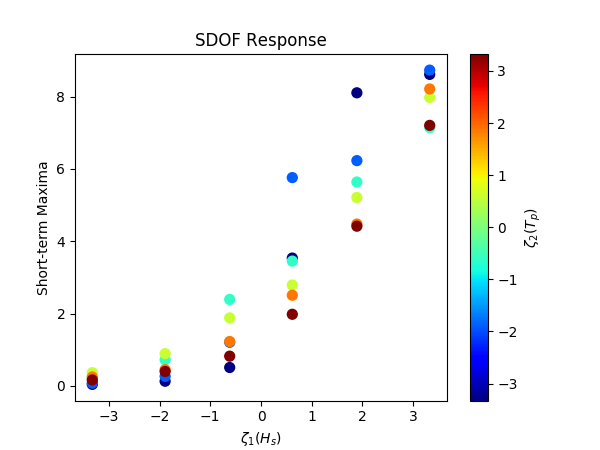

<IPython.core.display.Javascript object>


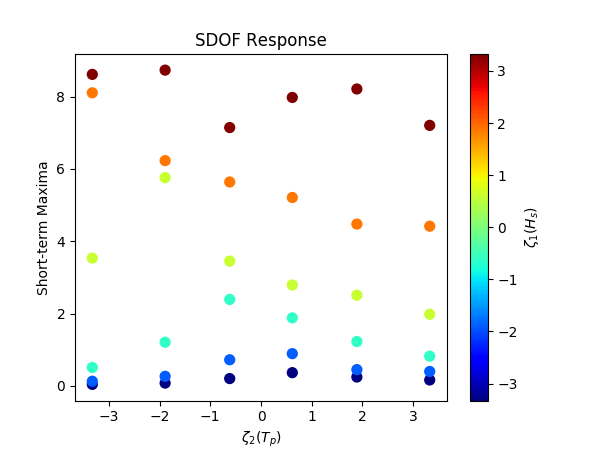

<IPython.core.display.Javascript object>


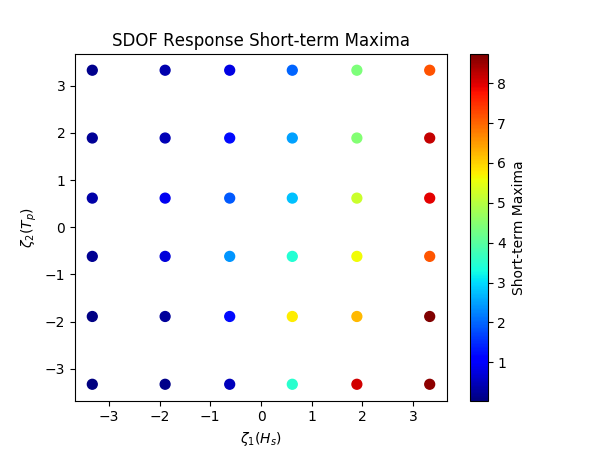

<IPython.core.display.Javascript object>


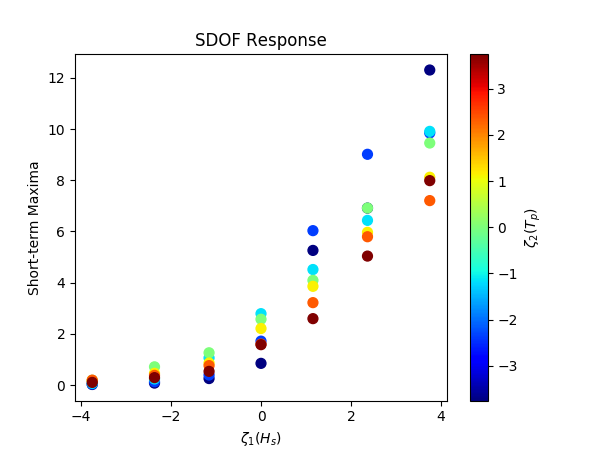

<IPython.core.display.Javascript object>


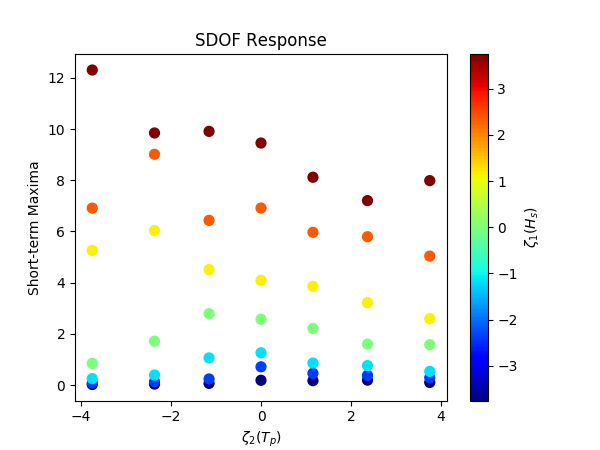

<IPython.core.display.Javascript object>


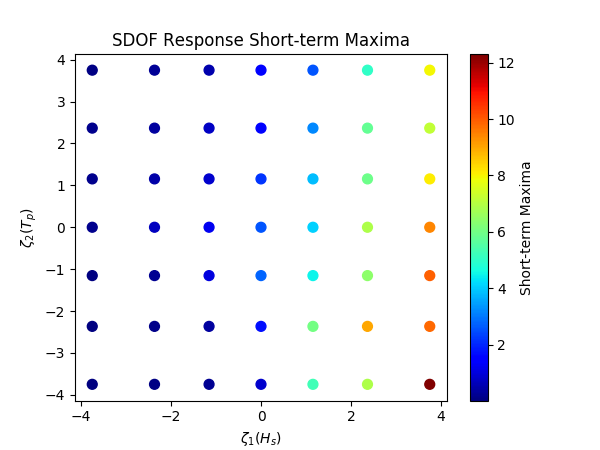

<IPython.core.display.Javascript object>


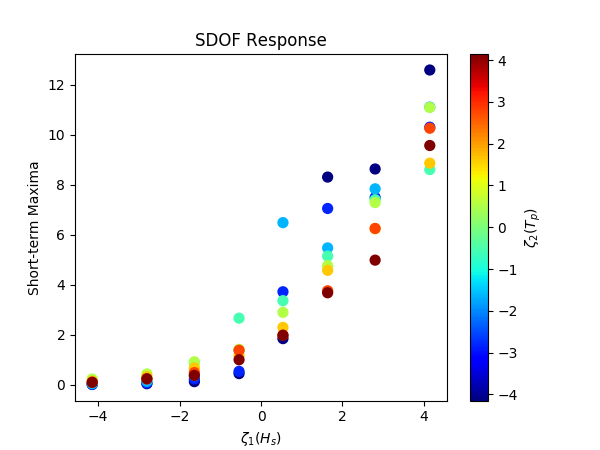

<IPython.core.display.Javascript object>


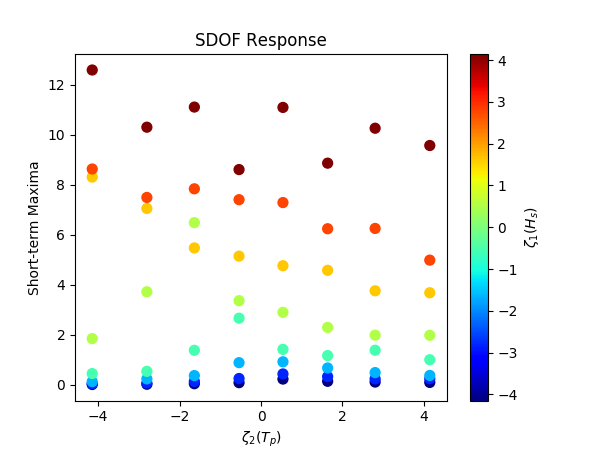

<IPython.core.display.Javascript object>


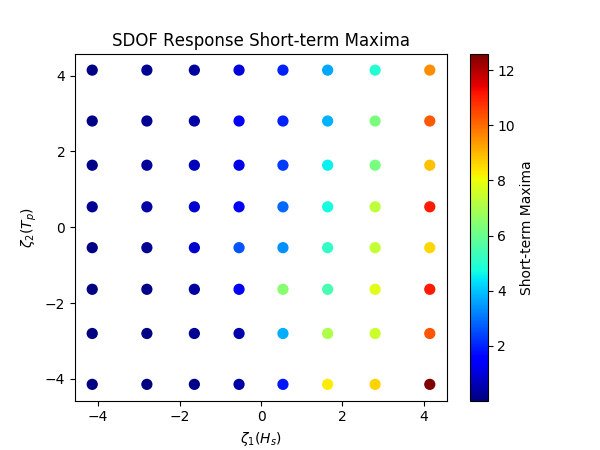

In [37]:
stats2analysis = 4 ##  [mean, std, skewness, kurtosis, absmax, absmin, up_crossing]
qoi2analysis   = 2 ## (t,eta,y,f,eta_pxx, y_pxx)
    
for idoe in np.arange(5,9):
    filename  = 'DoE_QuadHem{:d}.npy'.format(idoe)
    data_set  = np.load(os.path.join(MODEL_DIR_DATA,filename))
    train_zeta= data_set[:2,:]
    train_w   = data_set[2,:]
    train_x   = data_set[3:5,:]
    
    filename  = 'DoE_QuadHem{:d}_stats.npy'.format(idoe)
    data_set  = np.load(os.path.join(MODEL_DIR_DATA,filename))
    train_y   = np.squeeze(data_set[:, stats2analysis, qoi2analysis])
    
    fig       = plt.figure(figsize=figsize)    
    plt.scatter(train_zeta[0,:], train_y, c=train_zeta[1,:],s=50,cmap=cm.jet)
    plt.xlabel(r'$\zeta_1(H_s)$')
    plt.ylabel(r'Short-term Maxima')
    plt.title(r'SDOF Response')
    corbar = plt.colorbar()    
    corbar.set_label(r'$\zeta_2(T_p)$')
    plt.savefig(os.path.join(MODEL_DIR_FIGURE,'DoE_QuadHem{:d}_Yvs1.pdf'.format(idoe)))

    
    fig = plt.figure(figsize=figsize)    
    plt.scatter(train_zeta[1,:], train_y, c=train_zeta[0,:], s=50,cmap=cm.jet)
    plt.xlabel(r'$\zeta_2(T_p)$')
    plt.ylabel(r'Short-term Maxima')
    plt.title(r'SDOF Response')
    corbar = plt.colorbar()    
    corbar.set_label(r'$\zeta_1(H_s)$') 
    plt.savefig(os.path.join(MODEL_DIR_FIGURE,'DoE_QuadHem{:d}_Yvs2.pdf'.format(idoe)))
    
    fig = plt.figure(figsize=figsize)    
    plt.scatter(train_zeta[0,:], train_zeta[1,:], c=train_y, s=50,cmap=cm.jet)
    plt.xlabel(r'$\zeta_1(H_s)$')
    plt.ylabel(r'$\zeta_2(T_p)$')
    plt.title(r'SDOF Response Short-term Maxima')
    corbar = plt.colorbar()    
    corbar.set_label(r'Short-term Maxima')
    plt.savefig(os.path.join(MODEL_DIR_FIGURE,'DoE_QuadHem{:d}_Yvs12.pdf'.format(idoe)))



train x shape: (2, 25)
train y shape: (25,)
train eta shape: (25,)
pred  eta shape: (2, 25)


<IPython.core.display.Javascript object>


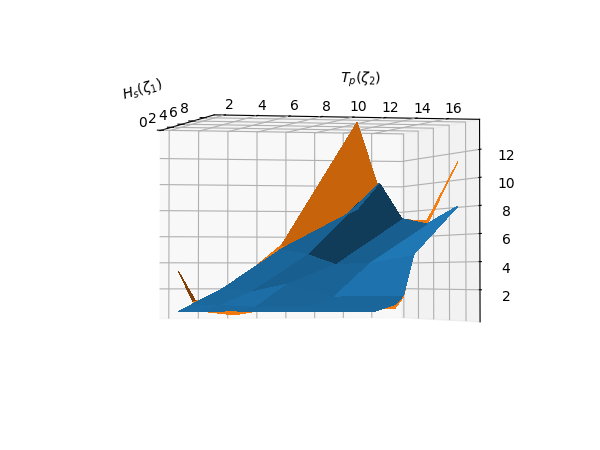

<IPython.core.display.Javascript object>


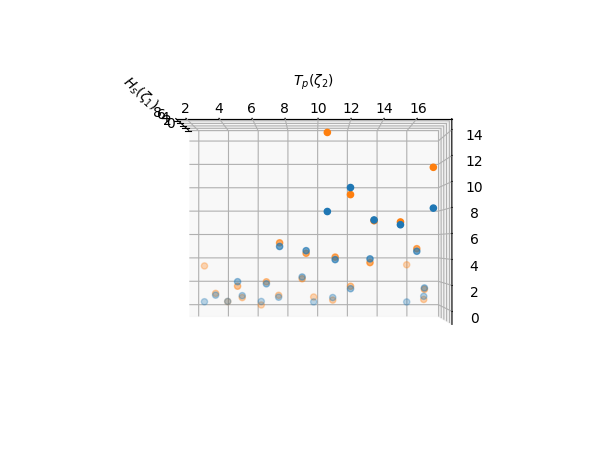

train x shape: (2, 36)
train y shape: (36,)
train eta shape: (36,)
pred  eta shape: (2, 36)


<IPython.core.display.Javascript object>


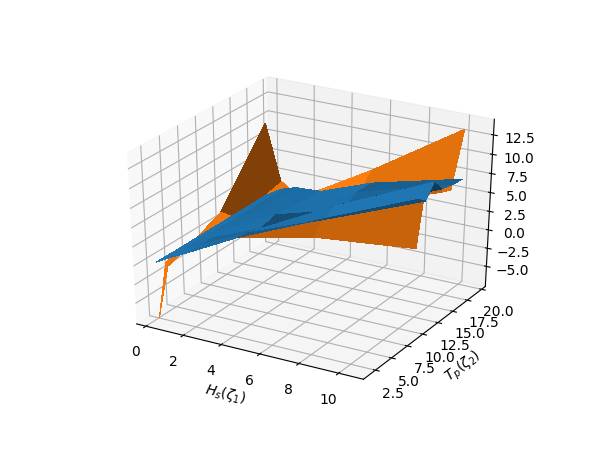

<IPython.core.display.Javascript object>


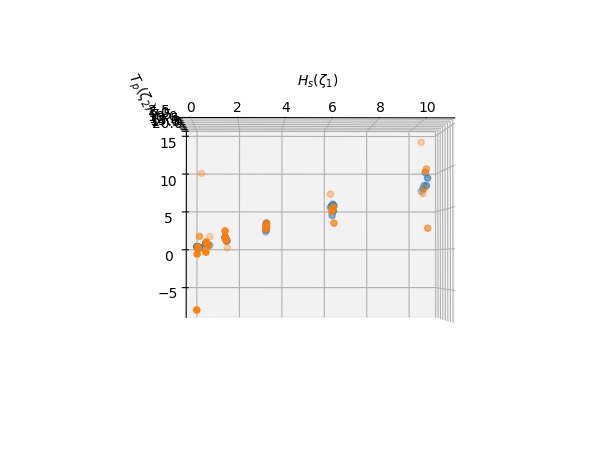

train x shape: (2, 49)
train y shape: (49,)
train eta shape: (49,)
pred  eta shape: (2, 49)


<IPython.core.display.Javascript object>


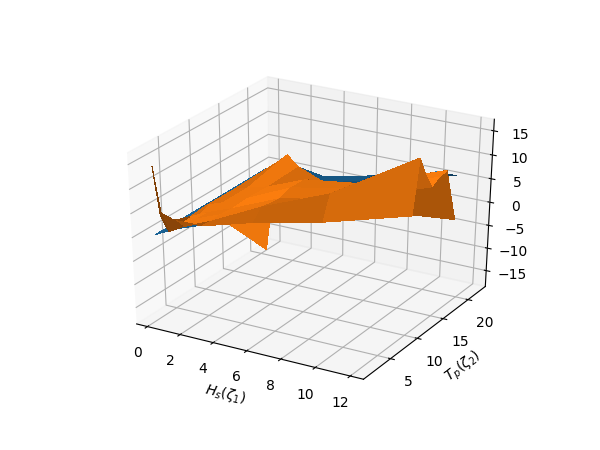

<IPython.core.display.Javascript object>


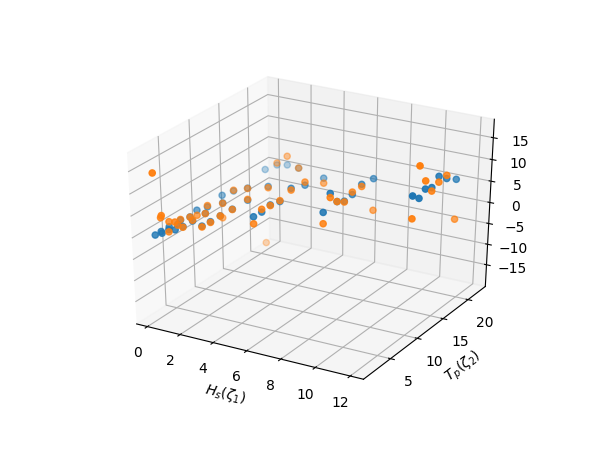

In [42]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm

for idoe in np.arange(5,8):
    filename  = 'DoE_QuadHem{:d}.npy'.format(idoe)
    data_set  = np.load(os.path.join(MODEL_DIR_DATA,filename))
    train_zeta= data_set[:2,:]
    train_w   = data_set[2,:]
    train_x   = data_set[3:5,:]
    
    filename  = 'DoE_QuadHem{:d}_stats.npy'.format(idoe)
    data_set  = np.load(os.path.join(MODEL_DIR_DATA,filename))
    train_eta = np.squeeze(data_set[:, 4, 1])#  [mean, std, skewness, kurtosis, absmax, absmin, up_crossing]
    train_y   = np.squeeze(data_set[:, 4, 2])
    filename  = 'DoE_QuadHem{:d}_valid.npy'.format(idoe)
    pred_eta  = np.load(os.path.join(MODEL_DIR_DATA,filename)).T
    print('train x shape: {}'.format(train_x.shape))
    print('train y shape: {}'.format(train_y.shape))
    print('train eta shape: {}'.format(train_eta.shape))
    print('pred  eta shape: {}'.format(pred_eta.shape))
#     print(train_zeta[0,:].reshape(5,5).T)
#     print(train_zeta[1,:].reshape(5,5).T)
    
#     fig = plt.figure(figsize=figsize)    
#     plt.scatter(train_zeta[0,:], train_y, c=train_zeta[1,:],s=50,cmap=cm.jet)
#     plt.xlabel(r'$\zeta_1(H_s)$')
#     plt.ylabel(r'Short-term Maxima')
#     plt.title(r'SDOF Response')
#     corbar = plt.colorbar()    
#     corbar.set_label(r'$\zeta_2(T_p)$')
#     plt.savefig(os.path.join(MODEL_DIR_FIGURE,'DoE_QuadHem{:d}_Yvs1.pdf'.format(idoe)))

#     fig = plt.figure(figsize=figsize)    
#     plt.scatter(train_zeta[1,:], train_y, c=train_zeta[0,:], s=50,cmap=cm.jet)
#     plt.xlabel(r'$\zeta_2(T_p)$')
#     plt.ylabel(r'Short-term Maxima')
#     plt.title(r'SDOF Response')
#     corbar = plt.colorbar()    
#     corbar.set_label(r'$\zeta_1(H_s)$') 
#     plt.savefig(os.path.join(MODEL_DIR_FIGURE,'DoE_QuadHem{:d}_Yvs2.pdf'.format(idoe)))
    
    fig = plt.figure(figsize=figsize)  
    ax  = fig.gca(projection='3d')
    x   = train_x[0,:].reshape(idoe,idoe).T
    y   = train_x[1,:].reshape(idoe,idoe).T
    z   = train_eta.reshape(idoe,idoe).T
    z0  = pred_eta[0,:].reshape(idoe,idoe).T
    surf = ax.plot_surface(x,y,z,linewidth=0, antialiased=False)
    surf = ax.plot_surface(x,y,z0,linewidth=0, antialiased=False)
    ax.set_xlabel(r'$H_s(\zeta_1)$')
    ax.set_ylabel(r'$T_p(\zeta_2)$')
    
    
    fig = plt.figure(figsize=figsize)  
    ax  = fig.gca(projection='3d')
    x   = train_x[0,:].reshape(idoe,idoe).T
    y   = train_x[1,:].reshape(idoe,idoe).T
    z   = train_eta.reshape(idoe,idoe).T
    z0  = pred_eta[0,:].reshape(idoe,idoe).T
    ax.scatter(train_x[0,:],train_x[1,:],train_eta)
    ax.scatter(train_x[0,:],train_x[1,:],pred_eta[0,:])
    ax.set_xlabel(r'$H_s(\zeta_1)$')
    ax.set_ylabel(r'$T_p(\zeta_2)$')
    
       
#     plt.scatter(train_x[0,:], train_x[1,:], c=train_y, s=50,cmap=cm.jet)
#     plt.xlabel(r'$\zeta_1(H_s)$')
#     plt.ylabel(r'$\zeta_2(T_p)$')
#     plt.title(r'SDOF Response Short-term Maxima')
#     corbar = plt.colorbar()    
#     corbar.set_label(r'Short-term Maxima')
#     plt.savefig(os.path.join(MODEL_DIR_FIGURE,'DoE_QuadHem{:d}_Yvs12.pdf'.format(idoe)))



[10.625728173662745, 11.83485056585165, 12.246288899288043]
[35.22529807660305, 39.221844541183785, 40.19756285958116]


/Users/jinsongliu/External/MUSE_UQ_DATA/linear_oscillator/Data


<IPython.core.display.Javascript object>


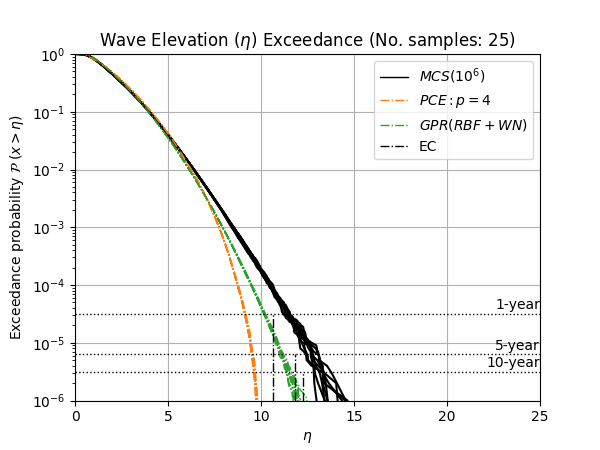

<IPython.core.display.Javascript object>


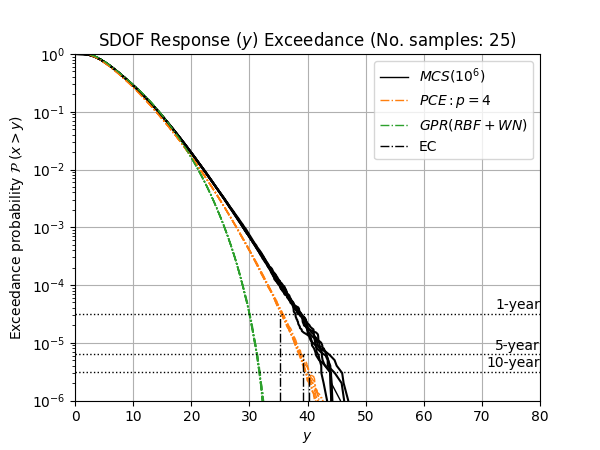

<IPython.core.display.Javascript object>


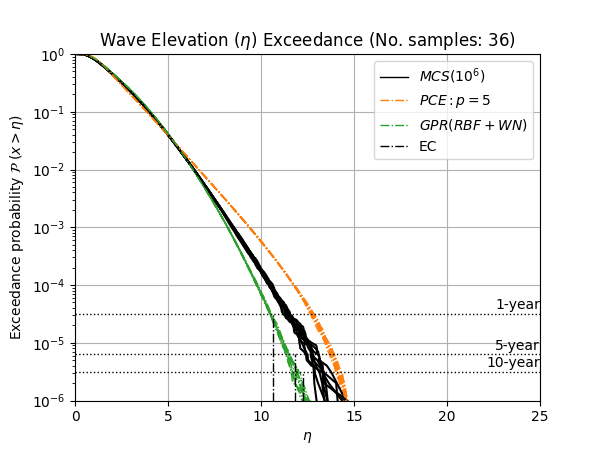

<IPython.core.display.Javascript object>


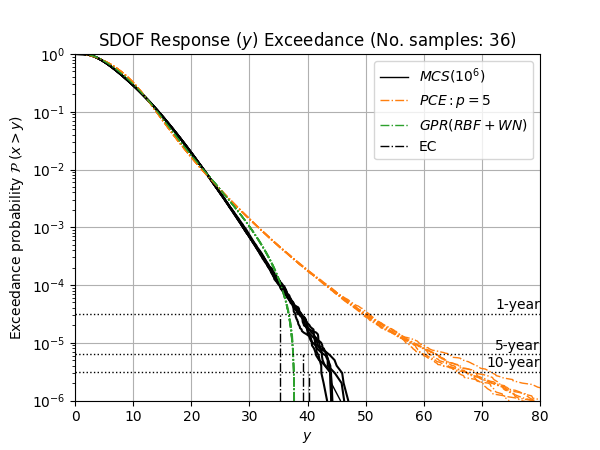

<IPython.core.display.Javascript object>


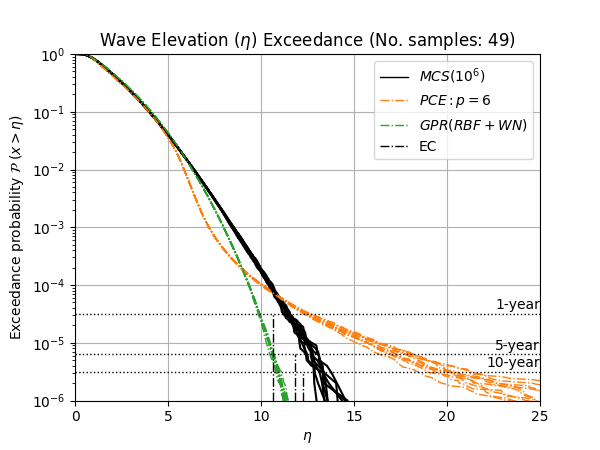

<IPython.core.display.Javascript object>


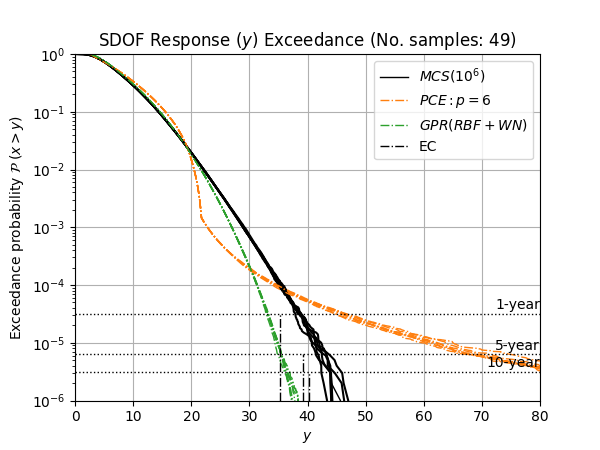

<IPython.core.display.Javascript object>


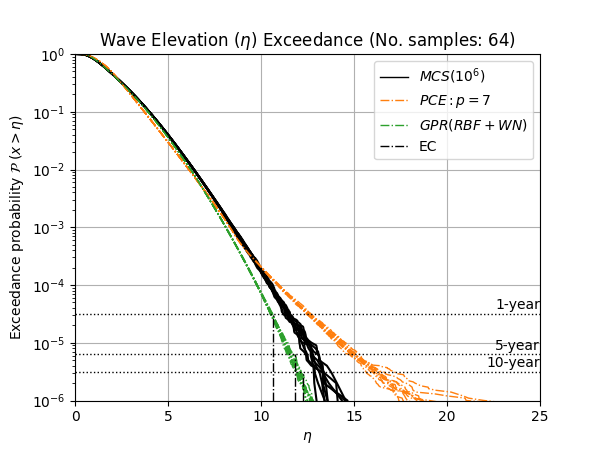

<IPython.core.display.Javascript object>


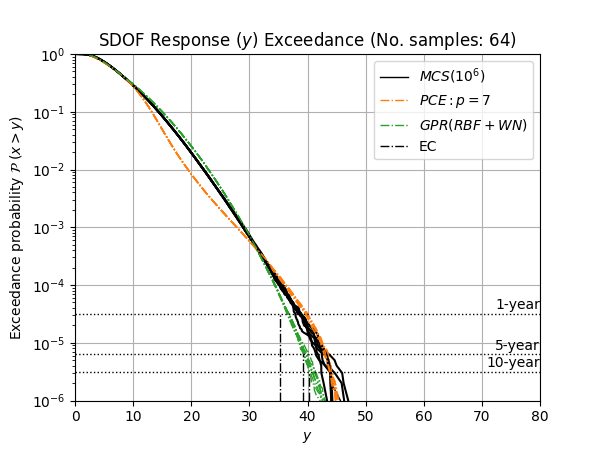

<IPython.core.display.Javascript object>


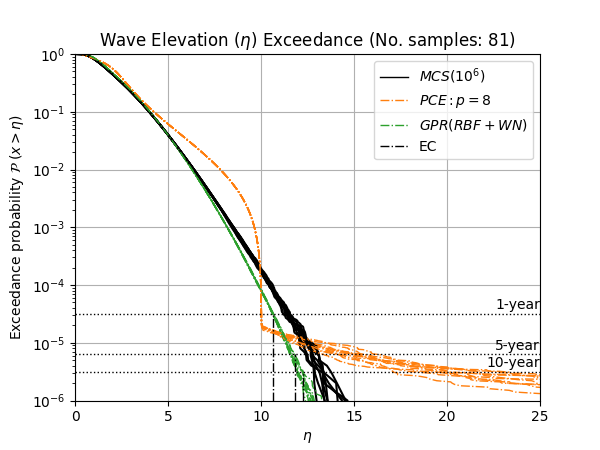

<IPython.core.display.Javascript object>


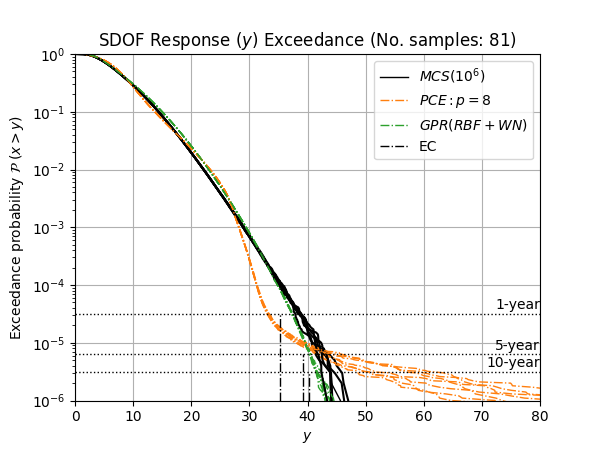

<IPython.core.display.Javascript object>


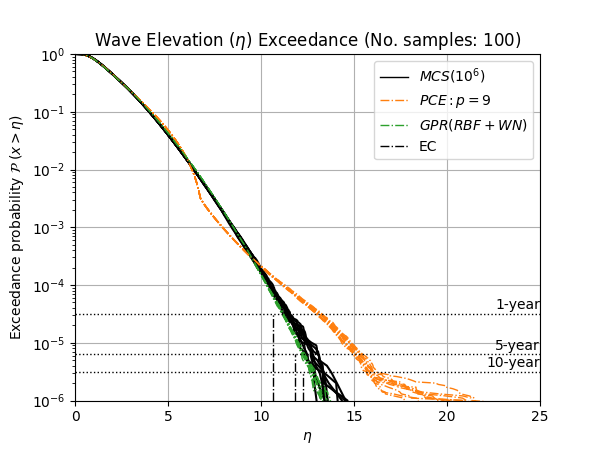

<IPython.core.display.Javascript object>


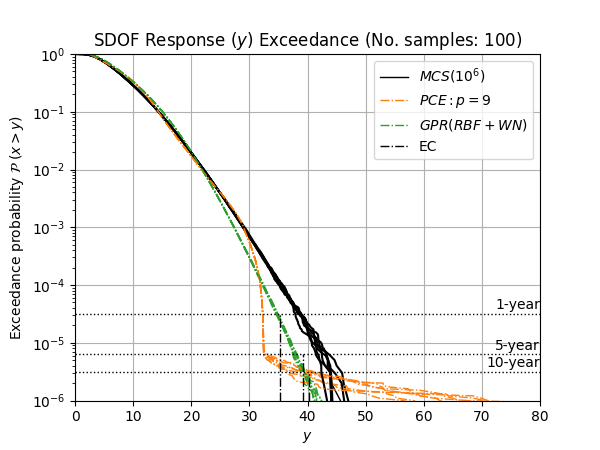

In [61]:
print(MODEL_DIR_DATA)
pf  = 1e-5
for quad_order in range(5,11):
    label_added = False
    fig2        = plt.figure(figsize=figsize)
    ax2         = fig2.add_subplot(1,1,1)
    nmcs_repeat           = range(10)
    mcs_exceedance_values = [] 
    pce_exceedance_values = [] 
    gpr_exceedance_values = [] 
    for imcs_repeat in nmcs_repeat:

        mcs_ecdf_filename = 'DoE_McRE6R{:d}_eta_ecdf_pf5.npy'.format(imcs_repeat)
        mcs_ecdf = np.load(os.path.join(MODEL_DIR_DATA, mcs_ecdf_filename)) 
        
        pce_mcs_ecdf_filename = 'DoE_QuadHem{:d}_pred_r{:d}_ecdf_pf5_eta.npy'.format(quad_order,imcs_repeat)
        pce_mcs_ecdf = np.load(os.path.join(MODEL_DIR_DATA, pce_mcs_ecdf_filename))    

        gpr_mcs_ecdf_filename = 'DoE_QuadHem{:d}_GPRx_pred_r{:d}_ecdf_pf5_eta.npy'.format(quad_order,imcs_repeat)
        gpr_mcs_ecdf = np.load(os.path.join(MODEL_DIR_DATA, gpr_mcs_ecdf_filename)) 
        
        if not label_added:
            # Ture model emperical exceedance plot with mcs results
            ax2.semilogy(mcs_ecdf[0,:], 1-mcs_ecdf[1,:],'k',linewidth=1, label=r'$MCS(10^6)$')
            # PCE model emperical exceedance plot with mcs results  
            ax2.semilogy(pce_mcs_ecdf[0,:], 1-pce_mcs_ecdf[1,:],'-.',
                         color=pltcolors[1],linewidth=1,label=r'$PCE: p={:>2d}$'.format(quad_order-1))
            ax2.semilogy(gpr_mcs_ecdf[0,:], 1-gpr_mcs_ecdf[1,:],'-.',
                         color=pltcolors[2],linewidth=1,label=r'$GPR(RBF+WN)$')
        else:
            ax2.semilogy(mcs_ecdf[0,:], 1-mcs_ecdf[1,:],'k')
            ax2.semilogy(pce_mcs_ecdf[0,:], 1-pce_mcs_ecdf[1,:],'-.',color=pltcolors[1],linewidth=1)  
            ax2.semilogy(gpr_mcs_ecdf[0,:], 1-gpr_mcs_ecdf[1,:],'-.',color=pltcolors[2],linewidth=1)  
            
        mcs_exceedance_values.append(mcs_ecdf[2,0])
        pce_exceedance_values.append(pce_mcs_ecdf[2,0])
        gpr_exceedance_values.append(gpr_mcs_ecdf[2,0])
        label_added =True

    ax2.set_xlim(0,25)
    ax2.set_ylim(pf/10,1)
    xmin, xmax = ax2.get_xlim()
    ymin, ymax = ax2.get_ylim()
    line1 = 1/(1 *365.25*24*3600/1000)
    line2 = 1/(5 *365.25*24*3600/1000)
    line3 = 1/(10*365.25*24*3600/1000)
    ax2.plot([xmin,xmax],[line1,line1],':k',linewidth=1)
    ax2.text(xmax,line1*1.2,r'1-year',horizontalalignment='right')
    ax2.plot([xmin,xmax],[line2,line2],':k',linewidth=1)
    ax2.text(xmax,line2*1.2,r'5-year',horizontalalignment='right')
    ax2.plot([xmin,xmax],[line3,line3],':k',linewidth=1)
    ax2.text(xmax,line3*1.2,r'10-year',horizontalalignment='right')
    ## EC results
    ax2.plot([ec_extreme_eta[0],ec_extreme_eta[0]],[ymin,line1],'-.k',linewidth=1,label=r'EC')
#     ax2.text(ec_extreme_eta[0]*0.8,line1*1.2,r'EC(1-year):{:.2f}'.format(ec_extreme_eta[0]),color='red')
    
    ax2.plot([ec_extreme_eta[1],ec_extreme_eta[1]],[ymin,line2],'-.k',linewidth=1)
#     ax2.text(ec_extreme_eta[1]*0.8,line2*1.2,r'EC(5-year):{:.2f}'.format(ec_extreme_eta[1]),color='red')
    
    ax2.plot([ec_extreme_eta[2],ec_extreme_eta[2]],[ymin,line3],'-.k',linewidth=1)
#     ax2.text(ec_extreme_eta[2]*0.8,line3*1.2,r'EC(10-year):{:.2f}'.format(ec_extreme_eta[2]),color='red')
    
    ax2.set_xlabel(r'$\eta$')
    ax2.set_ylabel(r'Exceedance probability $\mathcal{P}\;(x>\eta)$')
    ax2.set_title(r'Wave Elevation ($\eta$) Exceedance (No. samples: {:d})'.format(quad_order**2))
    plt.legend()
    plt.grid()
    # plt.show()
    plt.savefig(os.path.join(MODEL_DIR_FIGURE, r'ExceedancePlot_PCEGPR_DoE_Quadrature{:d}_eta.pdf'.format(quad_order)))


    label_added =False
    fig2 = plt.figure(figsize=figsize)
    ax2 = fig2.add_subplot(1,1,1)
    nmcs_repeat           = range(7)
    mcs_exceedance_values = [] 
    pce_exceedance_values = [] 
    gpr_exceedance_values = [] 
    for imcs_repeat in nmcs_repeat:

        mcs_ecdf_filename = 'DoE_McRE6R{:d}_y_ecdf_pf5.npy'.format(imcs_repeat)
        mcs_ecdf = np.load(os.path.join(MODEL_DIR_DATA, mcs_ecdf_filename))
        
        pce_mcs_ecdf_filename = 'DoE_QuadHem{:d}_pred_r{:d}_ecdf_pf5_y.npy'.format(quad_order,imcs_repeat)
        pce_mcs_ecdf = np.load(os.path.join(MODEL_DIR_DATA, pce_mcs_ecdf_filename)) 
        
        gpr_mcs_ecdf_filename = 'DoE_QuadHem{:d}_GPRx_pred_r{:d}_ecdf_pf5_y.npy'.format(quad_order,imcs_repeat)
        gpr_mcs_ecdf = np.load(os.path.join(MODEL_DIR_DATA, gpr_mcs_ecdf_filename))
        if not label_added:
            # Ture model emperical exceedance plot with mcs results
            ax2.semilogy(mcs_ecdf[0,:], 1-mcs_ecdf[1,:],'k',linewidth=1, label=r'$MCS(10^6)$')
            # PCE model emperical exceedance plot with mcs results  
            ax2.semilogy(pce_mcs_ecdf[0,:], 1-pce_mcs_ecdf[1,:],'-.',
                         color=pltcolors[1],linewidth=1,label=r'$PCE: p={:>2d}$'.format(quad_order-1))
            ax2.semilogy(gpr_mcs_ecdf[0,:], 1-gpr_mcs_ecdf[1,:],'-.',
                         color=pltcolors[2],linewidth=1,label=r'$GPR(RBF+WN)$')
        else:
            ax2.semilogy(mcs_ecdf[0,:], 1-mcs_ecdf[1,:],'k')
            ax2.semilogy(pce_mcs_ecdf[0,:], 1-pce_mcs_ecdf[1,:],'-.',color=pltcolors[1],linewidth=1)  
            ax2.semilogy(gpr_mcs_ecdf[0,:], 1-gpr_mcs_ecdf[1,:],'-.',color=pltcolors[2],linewidth=1) 

        mcs_exceedance_values.append(mcs_ecdf[2,0])
        pce_exceedance_values.append(pce_mcs_ecdf[2,0])
        gpr_exceedance_values.append(gpr_mcs_ecdf[2,0])
        label_added =True

    #     if not label_added:
    #         # GPR model emperical exceedance plot with mcs results
    #         ax2.semilogy(gpr_ecdf[imcs_repeat,0], 1-gpr_ecdf[imcs_repeat,1],'-.',color='b',linewidth=1,label=r'$GPR: RBF$')
    #     else:
    #         ax2.semilogy(gpr_ecdf[imcs_repeat,0], 1-gpr_ecdf[imcs_repeat,1],'-.',color='b',linewidth=1)              
    #     gpr_exceedance_values.append(gpr_ecdf[imcs_repeat,2][0])   


    # plt.semilogy(ecdf_y.x,1-ecdf_y.y, 'k',label=r'exact')
    # plt.semilogy(ecdf_y_norm.x,1-ecdf_y_norm.y, '-.r',label=r'normal error')
    # print(ecdf_y_pce)
    # for iecdf in ecdf_y_pce:
    ax2.set_xlim(0,80)
    ax2.set_ylim(pf/10,1)
    xmin, xmax = ax2.get_xlim()
    ymin, ymax = ax2.get_ylim()
    
    line1 = 1/(1 *365.25*24*3600/1000)
    line2 = 1/(5 *365.25*24*3600/1000)
    line3 = 1/(10*365.25*24*3600/1000)
    ax2.plot([xmin,xmax],[line1,line1],':k',linewidth=1)
    ax2.text(xmax,line1*1.2,r'1-year',horizontalalignment='right')
    ax2.plot([xmin,xmax],[line2,line2],':k',linewidth=1)
    ax2.text(xmax,line2*1.2,r'5-year',horizontalalignment='right')
    ax2.plot([xmin,xmax],[line3,line3],':k',linewidth=1)
    ax2.text(xmax,line3*1.2,r'10-year',horizontalalignment='right')
    
    ## EC results
    ax2.plot([ec_extreme_y[0],ec_extreme_y[0]],[ymin,line1],'-.k',linewidth=1,label=r'EC')
#     ax2.text(ec_extreme_y[0]*0.8,line1*1.2,r'EC(1-year):{:.2f}'.format(ec_extreme_y[0]),color='red')
    
    ax2.plot([ec_extreme_y[1],ec_extreme_y[1]],[ymin,line2],'-.k',linewidth=1)
#     ax2.text(ec_extreme_y[1]*0.8,line2*1.2,r'EC(5-year):{:.2f}'.format(ec_extreme_y[1]),color='red')
    
    ax2.plot([ec_extreme_y[2],ec_extreme_y[2]],[ymin,line3],'-.k',linewidth=1)
#     ax2.text(ec_extreme_y[2]*0.8,line3*1.2,r'EC(10-year):{:.2f}'.format(ec_extreme_y[2]),color='red')
    ax2.set_xlabel(r'$y$')
    ax2.set_ylabel(r'Exceedance probability $\mathcal{P}\;(x>y)$')
    ax2.set_title(r'SDOF Response ($y$) Exceedance (No. samples: {:d})'.format(quad_order**2))
    plt.legend()
    plt.grid()
    # plt.show()
    plt.savefig(os.path.join(MODEL_DIR_FIGURE, r'ExceedancePlot_PCEGPR_DoE_Quadrature{:d}_y.pdf'.format(quad_order)))





# 3. Monte Carlo

In [85]:
filename = 'DoE_McRE7R0.npy'
data_set = np.load(os.path.join(MODEL_DIR_DATA,filename))


FileNotFoundError: [Errno 2] No such file or directory: '/Users/jinsongliu/External/MUSE_UQ_DATA/linear_oscillator/Data/DoE_McRE7R0.npy'

In [20]:
print(data_set.shape)
samples_zeta = data_set[:2,:]
samples_x = data_set[2:,:]


(4, 10000000)


<IPython.core.display.Javascript object>


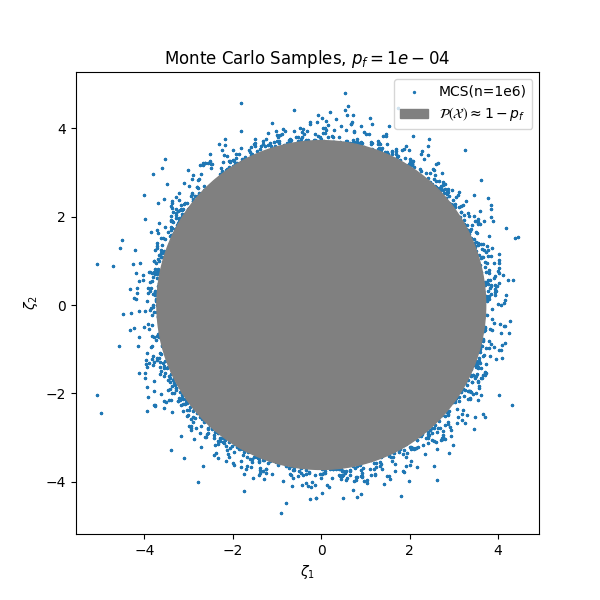

In [26]:
EC = make_circle(beta)
zeta_fig, zeta_ax = plt.subplots(figsize=(6,6))
plt_zeta_samples  = zeta_ax.scatter(x=samples_zeta[0,:1000000],y=samples_zeta[1,:1000000],s=2,zorder=0);
plt_circle        = plt.Circle((0, 0), beta, color='gray', zorder=10);
# plt_EC,           = zeta_ax.plot(EC[:,0],EC[:,1],'o',label=r'EC',color=pltcolors[1])

zeta_ax.add_artist(plt_zeta_samples)
zeta_ax.add_artist(plt_circle)
# zeta_ax.add_artist(plt_EC)

zeta_ax.set_xlabel(r'$\zeta_1$')
zeta_ax.set_ylabel(r'$\zeta_2$')
zeta_ax.set_title(r'Monte Carlo Samples, $p_f = {:.0e}$'.format(prob_fails))
zeta_ax.set_aspect('equal', 'box')
# zeta_ax.set_xlim(-np.floor(beta),np.floor(beta))
# zeta_ax.set_ylim(-np.floor(beta),np.floor(beta))
zeta_ax.legend([plt_zeta_samples,plt_circle],
               [r'MCS(n=1e6)', r'$\mathcal{P(X)}\approx 1-p_f$'],loc=1)
plt.savefig(os.path.join(MODEL_DIR_FIGURE, 'samples_zeta_joint.png'))

<IPython.core.display.Javascript object>


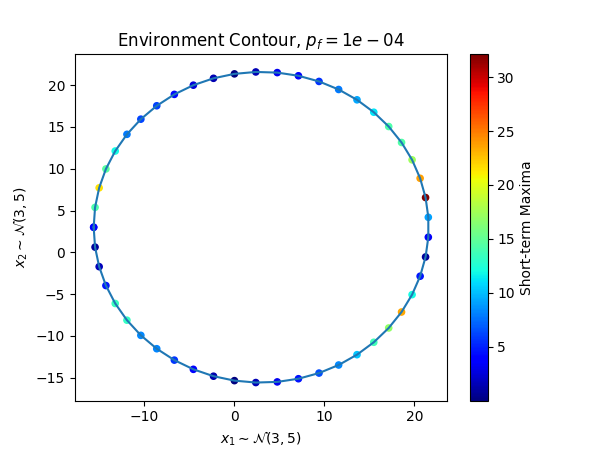

[4.40914275e+00 8.64405016e-01 1.66557676e+00 4.76604949e+00
 1.35599438e+01 1.32019447e+01 8.39015093e+00 8.19793745e+00
 5.72448988e+00 3.54283887e+00 1.28546564e+00 2.01323997e-02
 1.64637124e+00 3.25583473e+00 4.56031625e+00 6.42902271e+00
 8.36986025e+00 1.02484779e+01 1.37013782e+01 1.68604839e+01
 2.35976969e+01 1.19602118e+01 4.78424109e+00 7.76509308e-01
 3.43116680e+00 9.14420453e+00 3.21416861e+01 2.37727569e+01
 1.74101048e+01 1.43688129e+01 1.42518753e+01 1.11932094e+01
 9.38475176e+00 7.79968209e+00 5.65063069e+00 3.82681079e+00
 3.25258729e+00 1.63227750e+00 1.76441532e-02 1.52178092e+00
 2.59858948e+00 4.37818643e+00 6.10732982e+00 6.25706744e+00
 7.88222404e+00 1.20312139e+01 1.46590394e+01 2.15196150e+01
 1.42867619e+01 4.17107278e+00]


In [89]:
y_stats = np.load('test_linear_oscillator_EC_y_stats.npy')
y_st_max = np.squeeze(y_stats[:,4,2])

# fig_ec, axs_ec= plt.subplots(1,1,figsize=(4*1.5,3*1.5))
plt.figure(figsize=figsize)
plt.plot(EC_x[:,0],EC_x[:,1],'-')
plt.xlabel('$x_1\sim \mathcal{N}(3,5)$')
plt.ylabel('$x_2\sim \mathcal{N}(3,5)$')
plt.title('Environment Contour, $p_f={:.0e}$'.format(prob_fails));

plt.scatter(EC_x[:,0],EC_x[:,1], c=y_st_max, s=20,cmap=cm.jet)
# plt.aspect('equal', 'box')
corbar = plt.colorbar()    
corbar.set_label(r'Short-term Maxima')
print(y_st_max)

In [95]:
y_excd = np.squeeze(np.load('test_linear_oscillator_excd.npy'))
print(y_excd.shape)
# y_st_max = np.squeeze(y_stats[:,4,2])

# # fig_ec, axs_ec= plt.subplots(1,1,figsize=(4*1.5,3*1.5))
# plt.figure(figsize=figsize)
# plt.plot(EC_x[:,0],EC_x[:,1],'-')
# plt.xlabel('$x_1\sim \mathcal{N}(3,5)$')
# plt.ylabel('$x_2\sim \mathcal{N}(3,5)$')
# plt.title('Environment Contour, $p_f={:.0e}$'.format(prob_fails));

# plt.scatter(EC_x[:,0],EC_x[:,1], c=y_st_max, s=20,cmap=cm.jet)
# # plt.aspect('equal', 'box')
# corbar = plt.colorbar()    
# corbar.set_label(r'Short-term Maxima')
# print(y_st_max)

(3, 506)


In [ ]:
plt.savefig(os.path.join(MODEL_DIR_FIGURE, 'samples_zeta_joint.png'))

In [ ]:
plt.savefig(os.path.join(MODEL_DIR_FIGURE, 'samples_zeta_joint.pdf'))

In [ ]:
zeta_plot = sns.jointplot(x=samples_zeta[0,:],y=samples_zeta[1,:], scatter_kws={"s": 5});
zeta_plot.savefig(os.path.join(MODEL_DIR_FIGURE, 'samples_zeta_joint.pdf'))

In [ ]:
zeta_plot.savefig(os.path.join(MODEL_DIR_FIGURE, 'samples_zeta_joint.pdf'), quality=50)

## List of Benchmark problems

#### (I): Noise free case

In [ ]:
noise_type = 'DATA_NOISE_FREE'
pf = 1e-4

#### Fit model

In [ ]:
metamodel_class, metamodel_basis= ['PCE', [2,3,4]]
## Load data for one relization in selected domain [x,y,zeta] of size 1000
x,y,zeta = np.load(os.path.join(MODEL_DIR_DATA,r'bench4_realization_noise_free.npy'))
print(x[:5])

fig1 = plt.figure(figsize=figsize)
ax1 = fig1.add_subplot(1,1,1)
ax1.plot(x,y,'k',label=r'f(x)')
data_set = np.load(os.path.join(MODEL_DIR_DATA,'DATA_NOISE_FREE',r'TrainRes_PCE_DoE_Quadrature10.npy'))
print(len(data_set))
x_train    = data_set[0]
x_weight   = data_set[1]
y_train    = data_set[2]
zeta_train = data_set[3]
y_validate = data_set[4]
x_samples  = data_set[5]
y_samples  = data_set[6]
zeta_samples  = data_set[7]
y_samples_pred= data_set[8]
print('x_train shape: {}'.format(x_train.shape))
print('x_weight shape: {}'.format(x_weight.shape))
print('y_train shape: {}'.format(y_train.shape))
print('zeta_train shape: {}'.format(zeta_train.shape))
print('y_validate shape: {}'.format(y_validate.shape))
print('x_samples shape: {}'.format(x_samples.shape))
print('y_samples shape: {}'.format(y_samples.shape))
print('zeta_samples shape: {}'.format(zeta_samples.shape))
print('y_samples_pred shape: {}'.format(y_samples_pred.shape))

ax1.plot(x_train.T,y_train.T,'rx',zorder=9, label=r'Training Data')

for i, imetamodel_basis in enumerate(metamodel_basis):
    ax1.plot(x_train,y_validate[i,:],'o',
             markeredgecolor=pltcolors[i], markerfacecolor='w',
             label=r'$PCE: p={:d}$'.format(imetamodel_basis))
    ax1.plot(x_samples,y_samples_pred[i,:],'-',color=pltcolors[i],alpha=0.4)

ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title(r'Surrogate models for Polynomial function: $(\epsilon=0)$')

In [ ]:
metamodel_class, metamodel_basis = ['GPR', ['RBF']]
data_set   = np.load(os.path.join(MODEL_DIR_DATA,'DATA_NOISE_FREE',r'TrainRes_GPR_DoE_Quadrature10.npy'))
print(len(data_set))
x_train    = np.squeeze(data_set[0])
y_train    = np.squeeze(data_set[1])
zeta_train = np.squeeze(data_set[2])
y_validate = np.squeeze(data_set[3][0,:])
y_valid_std= np.squeeze(data_set[3][1,:])
x_samples  = data_set[4]
y_samples  = data_set[5]
zeta_samples = data_set[6]
y_samples_pred = data_set[7]
print('data set element shape:')
print('{:20s}: {}'.format('x_train',    x_train.shape))
print('{:20s}: {}'.format('y_train',    y_train.shape))
print('{:20s}: {}'.format('zeta_train', zeta_train.shape))
print('{:20s}: {}'.format('y_validate', y_validate.shape))
print('{:20s}: {}'.format('y_validate_std', y_valid_std.shape))
print('{:20s}: {}'.format('x_samples',  x_samples.shape))
print('{:20s}: {}'.format('y_samples',  y_samples.shape))
print('{:20s}: {}'.format('zeta_samples',zeta_samples.shape))
print('{:20s}: {}'.format('y_samples_pred',y_samples_pred.shape))


ax1.plot(x_train,y_validate,'o', markeredgecolor='b', markerfacecolor='w', label=r'GPR: RBF')

ax1.plot(x_samples,y_samples_pred[0,:],'-', color='b')
ax1.fill_between(x_samples, y_samples_pred[0,:] - 1.96*y_samples_pred[1,:], y_samples_pred[0,:] + 1.96*y_samples_pred[1,:],
                 color='b',alpha=0.2,edgecolor='None',label='GPR: 95% CI')
ax1.legend()



In [ ]:
ax1.legend()
loc2savefig = os.path.join(MODEL_DIR_FIGURE, r'Polynomial_{}_DoE_Quadrature10.pdf'.format(metamodel_class)) 
print('Figures saved to: {}'.format(loc2savefig))
fig1.savefig(loc2savefig)

#### Exceedance plot

In [ ]:
print(MODEL_DIR_DATA)
metamodel_class, metamodel_basis= ['GPR_PCE', list(np.arange(2,5))]
pce_exceedance_values = []
# ndoe2plot = list(np.arange(10,16))
ndoe2plot = metamodel_basis
label_added =False
fig2 = plt.figure(figsize=figsize)
ax2 = fig2.add_subplot(1,1,1)

mcs_ecdf = np.load(os.path.join(MODEL_DIR_DATA,noise_type,r'Ecdf_pf4_MCS7.npy'))
pce_ecdf  = np.load(os.path.join(MODEL_DIR_DATA,noise_type,r'Ecdf_pf4_PCE_DoE_Quadrature10_MCS7.npy'))
gpr_ecdf  = np.load(os.path.join(MODEL_DIR_DATA,noise_type,r'Ecdf_pf4_GPR_DoE_Quadrature10_MCS7.npy'))
nmcs_repeat   = mcs_ecdf.shape[0]
mcs_exceedance_values = [] 
pce_exceedance_values = [] 
gpr_exceedance_values = [] 
for imcs_repeat in range(nmcs_repeat):
     
    if not label_added:
        #Ture model emperical exceedance plot with mcs results
        ax2.semilogy(mcs_ecdf[imcs_repeat,0], 1-mcs_ecdf[imcs_repeat,1],'k', label=r'$f(x)$')
#         # GPR model emperical exceedance plot with mcs results
    else:
        ax2.semilogy(mcs_ecdf[imcs_repeat,0], 1-mcs_ecdf[imcs_repeat,1],'k')
    mcs_exceedance_values.append(mcs_ecdf[imcs_repeat,2][0])
    
    # PCE model emperical exceedance plot with mcs results
    for i, idoe in enumerate(ndoe2plot):
#         exceedance_values.append(pce_mcs_ecdf[imcs_repeat,2,i][0])
#         print(iecdf.shape)
        if not label_added:
            ax2.semilogy(pce_ecdf[imcs_repeat,i,0], 1-pce_ecdf[imcs_repeat,i,1],'-.',color=pltcolors[i],linewidth=1,label=r'$PCE: p={:>2d}$'.format(idoe))
        else:
            ax2.semilogy(pce_ecdf[imcs_repeat,i,0], 1-pce_ecdf[imcs_repeat,i,1],'-.',color=pltcolors[i],linewidth=1)  
    pce_exceedance_values.append(pce_ecdf[imcs_repeat,i,2][0])
    if not label_added:
        # GPR model emperical exceedance plot with mcs results
        ax2.semilogy(gpr_ecdf[imcs_repeat,0], 1-gpr_ecdf[imcs_repeat,1],'-.',color='b',linewidth=1,label=r'$GPR: RBF$')
    else:
        ax2.semilogy(gpr_ecdf[imcs_repeat,0], 1-gpr_ecdf[imcs_repeat,1],'-.',color='b',linewidth=1)              
    gpr_exceedance_values.append(gpr_ecdf[imcs_repeat,2][0])        
    label_added =True
       
# plt.semilogy(ecdf_y.x,1-ecdf_y.y, 'k',label=r'exact')
# plt.semilogy(ecdf_y_norm.x,1-ecdf_y_norm.y, '-.r',label=r'normal error')
# print(ecdf_y_pce)
# for iecdf in ecdf_y_pce:
ax2.set_xlim(-10,75)
ax2.set_ylim(pf/10,1)
xmin, xmax = ax2.get_xlim()
ymin, ymax = ax2.get_ylim()
ax2.plot([xmin,xmax],[pf,pf],':r',linewidth=1)
ax2.text(xmax*0.8,pf*1.2,r'$p_f={:.0e}$'.format(pf))

ax2.set_xlabel(r'$y$')
ax2.set_ylabel(r'Exceedance probability $\mathcal{P}\;(Y>y)$')
ax2.set_title(r'Exceedance plot: $f(x)$ v.s $\hat{f}(x)$')
plt.legend()
plt.grid()
# plt.show()
plt.savefig(os.path.join(MODEL_DIR_FIGURE, r'ExceedancePlot_{}_DoE_Quadrature10.pdf'.format(metamodel_class)))


In [ ]:
print('Exceedance values from MCS:')
print('-'*40)
print('{:12s}: {:6s}   {:6s}'.format('', 'Mean', 'Variance'))
print('{:12s}: {:.4f}   {:.4f}'.format('True Model', np.mean(mcs_exceedance_values), np.std(mcs_exceedance_values)**2))
print('{:12s}: {:.4f}   {:.4f}'.format('PCE Model', np.mean(pce_exceedance_values), np.std(pce_exceedance_values)**2))
print('{:12s}: {:.4f}   {:.4f}'.format('GPR Model', np.mean(gpr_exceedance_values), np.std(gpr_exceedance_values)**2))


In [ ]:
pf=1e-5
metamodel_class, metamodel_basis= ['GPR_PCE', list(np.arange(2,5))]
pce_exceedance_values = []
# ndoe2plot = list(np.arange(10,16))
ndoe2plot = metamodel_basis
label_added =False
fig2 = plt.figure(figsize=figsize)
ax2 = fig2.add_subplot(1,1,1)

mcs_ecdf = np.load(os.path.join(MODEL_DIR_DATA,noise_type,r'Ecdf_pf5_MCS7.npy'))
pce_ecdf  = np.load(os.path.join(MODEL_DIR_DATA,noise_type,r'Ecdf_pf5_PCE_DoE_Quadrature10_MCS7.npy'))
gpr_ecdf  = np.load(os.path.join(MODEL_DIR_DATA,noise_type,r'Ecdf_pf5_GPR_DoE_Quadrature10_MCS7.npy'))
nmcs_repeat   = mcs_ecdf.shape[0]
mcs_exceedance_values = [] 
pce_exceedance_values = [] 
gpr_exceedance_values = [] 
for imcs_repeat in range(nmcs_repeat):
     
    if not label_added:
        #Ture model emperical exceedance plot with mcs results
        ax2.semilogy(mcs_ecdf[imcs_repeat,0], 1-mcs_ecdf[imcs_repeat,1],'k', label=r'$f(x)$')
#         # GPR model emperical exceedance plot with mcs results
    else:
        ax2.semilogy(mcs_ecdf[imcs_repeat,0], 1-mcs_ecdf[imcs_repeat,1],'k')
    mcs_exceedance_values.append(mcs_ecdf[imcs_repeat,2][0])
    
    # PCE model emperical exceedance plot with mcs results
    for i, idoe in enumerate(ndoe2plot):
#         exceedance_values.append(pce_mcs_ecdf[imcs_repeat,2,i][0])
#         print(iecdf.shape)
        if not label_added:
            ax2.semilogy(pce_ecdf[imcs_repeat,i,0], 1-pce_ecdf[imcs_repeat,i,1],'-.',color=pltcolors[i],linewidth=1,label=r'$PCE: p={:>2d}$'.format(idoe))
        else:
            ax2.semilogy(pce_ecdf[imcs_repeat,i,0], 1-pce_ecdf[imcs_repeat,i,1],'-.',color=pltcolors[i],linewidth=1)  
    pce_exceedance_values.append(pce_ecdf[imcs_repeat,i,2][0])
    if not label_added:
        # GPR model emperical exceedance plot with mcs results
        ax2.semilogy(gpr_ecdf[imcs_repeat,0], 1-gpr_ecdf[imcs_repeat,1],'-.',color='b',linewidth=1,label=r'$GPR: RBF$')
    else:
        ax2.semilogy(gpr_ecdf[imcs_repeat,0], 1-gpr_ecdf[imcs_repeat,1],'-.',color='b',linewidth=1)              
    gpr_exceedance_values.append(gpr_ecdf[imcs_repeat,2][0])        
    label_added =True
       
# plt.semilogy(ecdf_y.x,1-ecdf_y.y, 'k',label=r'exact')
# plt.semilogy(ecdf_y_norm.x,1-ecdf_y_norm.y, '-.r',label=r'normal error')
# print(ecdf_y_pce)
# for iecdf in ecdf_y_pce:
ax2.set_xlim(-10,100)
ax2.set_ylim(pf/10,1)
xmin, xmax = ax2.get_xlim()
ymin, ymax = ax2.get_ylim()
ax2.plot([xmin,xmax],[pf,pf],':r',linewidth=1)
ax2.text(xmax*0.8,pf*1.2,r'$p_f={:.0e}$'.format(pf))

ax2.set_xlabel(r'$y$')
ax2.set_ylabel(r'Exceedance probability $\mathcal{P}\;(Y>y)$')
ax2.set_title(r'Exceedance plot: $f(x)$ v.s $\hat{f}(x)$')
plt.legend()
plt.grid()
# plt.show()
plt.savefig(os.path.join(MODEL_DIR_FIGURE, r'ExceedancePlot_{}_DoE_Quadrature10.pdf'.format(metamodel_class)))

In [ ]:
print('Exceedance values from MCS:')
print('-'*40)
print('{:12s}: {:6s}   {:6s}'.format('', 'Mean', 'Variance'))
print('{:12s}: {:.4f}   {:.4f}'.format('True Model', np.mean(mcs_exceedance_values), np.std(mcs_exceedance_values)**2))
print('{:12s}: {:.4f}   {:.4f}'.format('PCE Model', np.mean(pce_exceedance_values), np.std(pce_exceedance_values)**2))
print('{:12s}: {:.4f}   {:.4f}'.format('GPR Model', np.mean(gpr_exceedance_values), np.std(gpr_exceedance_values)**2))


In [ ]:
pf=1e-6
metamodel_class, metamodel_basis= ['GPR_PCE', list(np.arange(2,5))]
pce_exceedance_values = []
# ndoe2plot = list(np.arange(10,16))
ndoe2plot = metamodel_basis
label_added =False
fig2 = plt.figure(figsize=figsize)
ax2 = fig2.add_subplot(1,1,1)

mcs_ecdf = np.load(os.path.join(MODEL_DIR_DATA,noise_type,r'Ecdf_pf6_MCS7.npy'))
pce_ecdf  = np.load(os.path.join(MODEL_DIR_DATA,noise_type,r'Ecdf_pf6_PCE_DoE_Quadrature10_MCS7.npy'))
gpr_ecdf  = np.load(os.path.join(MODEL_DIR_DATA,noise_type,r'Ecdf_pf6_GPR_DoE_Quadrature10_MCS7.npy'))
nmcs_repeat   = mcs_ecdf.shape[0]
mcs_exceedance_values = [] 
pce_exceedance_values = [] 
gpr_exceedance_values = [] 
for imcs_repeat in range(nmcs_repeat):
     
    if not label_added:
        #Ture model emperical exceedance plot with mcs results
        ax2.semilogy(mcs_ecdf[imcs_repeat,0], 1-mcs_ecdf[imcs_repeat,1],'k', label=r'$f(x)$')
#         # GPR model emperical exceedance plot with mcs results
    else:
        ax2.semilogy(mcs_ecdf[imcs_repeat,0], 1-mcs_ecdf[imcs_repeat,1],'k')
    mcs_exceedance_values.append(mcs_ecdf[imcs_repeat,2][0])
    
    # PCE model emperical exceedance plot with mcs results
    for i, idoe in enumerate(ndoe2plot):
#         exceedance_values.append(pce_mcs_ecdf[imcs_repeat,2,i][0])
#         print(iecdf.shape)
        if not label_added:
            ax2.semilogy(pce_ecdf[imcs_repeat,i,0], 1-pce_ecdf[imcs_repeat,i,1],'-.',color=pltcolors[i],linewidth=1,label=r'$PCE: p={:>2d}$'.format(idoe))
        else:
            ax2.semilogy(pce_ecdf[imcs_repeat,i,0], 1-pce_ecdf[imcs_repeat,i,1],'-.',color=pltcolors[i],linewidth=1)  
    pce_exceedance_values.append(pce_ecdf[imcs_repeat,i,2][0])
    if not label_added:
        # GPR model emperical exceedance plot with mcs results
        ax2.semilogy(gpr_ecdf[imcs_repeat,0], 1-gpr_ecdf[imcs_repeat,1],'-.',color='b',linewidth=1,label=r'$GPR: RBF$')
    else:
        ax2.semilogy(gpr_ecdf[imcs_repeat,0], 1-gpr_ecdf[imcs_repeat,1],'-.',color='b',linewidth=1)              
    gpr_exceedance_values.append(gpr_ecdf[imcs_repeat,2][0])        
    label_added =True
       
# plt.semilogy(ecdf_y.x,1-ecdf_y.y, 'k',label=r'exact')
# plt.semilogy(ecdf_y_norm.x,1-ecdf_y_norm.y, '-.r',label=r'normal error')
# print(ecdf_y_pce)
# for iecdf in ecdf_y_pce:
ax2.set_xlim(-10,150)
ax2.set_ylim(pf/10,1)
xmin, xmax = ax2.get_xlim()
ymin, ymax = ax2.get_ylim()
ax2.plot([xmin,xmax],[pf,pf],':r',linewidth=1)
ax2.text(xmax*0.8,pf*1.2,r'$p_f={:.0e}$'.format(pf))

ax2.set_xlabel(r'$y$')
ax2.set_ylabel(r'Exceedance probability $\mathcal{P}\;(Y>y)$')
ax2.set_title(r'Exceedance plot: $f(x)$ v.s $\hat{f}(x)$')
plt.legend()
plt.grid()
# plt.show()
plt.savefig(os.path.join(MODEL_DIR_FIGURE, r'ExceedancePlot_{}_DoE_Quadrature10.pdf'.format(metamodel_class)))

In [ ]:
print('Exceedance values from MCS:')
print('-'*40)
print('{:12s}: {:6s}   {:6s}'.format('', 'Mean', 'Variance'))
print('{:12s}: {:.4f}   {:.4f}'.format('True Model', np.mean(mcs_exceedance_values), np.std(mcs_exceedance_values)**2))
print('{:12s}: {:.4f}   {:.4f}'.format('PCE Model', np.mean(pce_exceedance_values), np.std(pce_exceedance_values)**2))
print('{:12s}: {:.4f}   {:.4f}'.format('GPR Model', np.mean(gpr_exceedance_values), np.std(gpr_exceedance_values)**2))

In [ ]:
a = np.arange(10).reshape(5,2)
print(a)
for ia in a:
    print(ia.shape)

### 2   Benchmark 1

In [ ]:
label_added =False
fig = plt.figure(figsize=(4*1.5,3*1.5))
ax = fig.add_subplot(1,1,1)
print(len(true_y_mcs_ecdf2plot))
for iecdf2plot in true_y_mcs_ecdf2plot:
    if not label_added:
        ax.semilogy(iecdf2plot.x, 1-iecdf2plot.y,'k', label=r'$f(x)$')
        label_added =True
    else:
        ax.semilogy(iecdf2plot.x, 1-iecdf2plot.y,'k')    
label_added =False    
for imetamodel_ecdfs in metamodel_y_gpr_mcs_ecdf2plot:
    iecdf2plot = imetamodel_ecdfs
   
    if not label_added:
        ax.semilogy(iecdf2plot.x, 1-iecdf2plot.y,'-.',color='b',linewidth=1, label=r'GPR RBF:')
        label_added =True
    else:
        ax.semilogy(iecdf2plot.x, 1-iecdf2plot.y,'-.',color='b',linewidth=1)
#     print(i)
        
# plt.semilogy(ecdf_y.x,1-ecdf_y.y, 'k',label=r'exact')
# plt.semilogy(ecdf_y_norm.x,1-ecdf_y_norm.y, '-.r',label=r'normal error')
# print(ecdf_y_pce)
# for iecdf in ecdf_y_pce:

ax.set_xlim(0,80)
ax.set_ylim(1e-5,2)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.plot([xmin,xmax],[pf,pf],'-.r')
ax.text(5,pf*1.2,r'$p_f={:.0e}$'.format(pf))

ax.set_xlabel(r'$y$')
ax.set_ylabel(r'Exceedance probability $\mathcal{P}\;(Y>y)$')
ax.set_title(r'Exceedance plot: $f(x)$ v.s $\hat{f}(x)$')
plt.legend()
plt.grid()
plt.savefig(os.path.join(MODEL_DIR_FIGURE, r'ExceedancePlot_{}_DoE0.pdf'.format(metamodel_class)))

In [ ]:
x_fix = np.linspace(-5,15,1000)[np.newaxis, :]
metamodel_class, metamodel_basis = ['GPR', 'RBF']

data_set = np.load(os.path.join(MODEL_DIR_DATA,'Noise_free',r'True_domain_FIX_DoE_fix0.npy'))
x,y = data_set[0].T,data_set[1].T
# print(data_set[0].shape, data_set[1].shape)
# print(x.shape, y.shape)
plt.figure()
plt.plot(x,y,'k',label=r'f(x)')
data_set = np.load(os.path.join(MODEL_DIR_DATA,'Noise_free',r'aDoE_Quadrature_hermite_train_GPR0.npy'))
print(len(data_set))
x_train    = np.squeeze(data_set[0][0])
x_weight   = np.squeeze(data_set[0][1])
y_train    = np.squeeze(data_set[1])
zeta_train = np.squeeze(data_set[2][0])
y_validate = np.squeeze(data_set[3][0,:])
y_valid_std= np.squeeze(data_set[3][1,:])
x_test     = np.squeeze(data_set[4])
y_test_mean= np.squeeze(data_set[6][0,:])
y_test_std = np.squeeze(data_set[6][1,:])
print(data_set[3].shape)
print(x_train.shape,y_validate.shape)
plt.plot(x_train,y_train,'rx',zorder=9, label=r'Training Data')

plt.plot(x_train,y_validate,'o', markeredgecolor='b', markerfacecolor='w', label=r'GPR: RBF')

plt.plot(x_test,y_test_mean,'-', color='b')
plt.fill_between(x_test, y_test_mean - 1.96*y_test_std, y_test_mean + 1.96*y_test_std,
                 color='b',alpha=0.2,edgecolor='None',label='95% confidence interval')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'{} surrogate model: {} $(\epsilon=0)$'.format(metamodel_class,MODEL_NAME))
plt.savefig(os.path.join(MODEL_DIR_FIGURE, r'{}_DoE0.pdf'.format(metamodel_class)))

In [ ]:
metamodel_y_mcs_ecdf = [[] for _ in range(len(metamodel_basis))] 
metamodel_y_mcs_ecdf2plot = [[] for _ in range(len(metamodel_basis))]
print(data_set.shape)
metamodel_zeta_mcs = data_set[:,0]
metamodel_y_mcs    = data_set[:,1]
print(metamodel_y_mcs[0].shape)

for metamodel_zeta_mcs_r in metamodel_zeta_mcs:
    for i, imetamodel_zeta_mcs in enumerate(metamodel_zeta_mcs_r):
        print(np.round(imetamodel_zeta_mcs[:5],4))

for metamodel_y_mcs_r in metamodel_y_mcs:
    for i, imetamodel_y_mcs in enumerate(metamodel_y_mcs_r):
        iecdf = ECDF(np.squeeze(imetamodel_y_mcs))
        metamodel_y_mcs_ecdf[i].append(iecdf)
        
        indx1 = np.linspace(0,len(iecdf.x)-windowlength2plot, windowlength2plot, dtype=np.int32)
        indx2 = np.arange(indx1[-1]+1,len(iecdf.x),dtype=np.int32)
        indx  = np.hstack((indx1,indx2))
        metamodel_y_mcs_ecdf2plot[i].append(Ecdf2plot(iecdf.x[indx],iecdf.y[indx]))


In [ ]:
plt.savefig(os.path.join(MODEL_DIR_FIGURE, r'ExceedancePlot_{}_DoE0_zoomin.pdf'.format(metamodel_class)))


In [ ]:
plt.figure(figsize=(4*1.5, 3*1.5))
plt.subplot(1, 1, 1)
kernel  = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 1e4))
lim,res = [-5,20], 191
rng = np.random.RandomState(3)
# Training Data
x_fix = np.linspace(-5,15,1000)[np.newaxis, :]

data_set = np.load(os.path.join(MODEL_DIR_DATA,'Noise_free',r'True_domain_FIX_DoE_fix0.npy'))
x,y = data_set[0].T,data_set[1].T
# print(data_set[0].shape, data_set[1].shape)
plt.plot(x,y,'k',label=r'f(x)')
data_set = np.load(os.path.join(MODEL_DIR_DATA,'Noise_free',r'Train_Quadrature_hermite_PCE_doe0.npy'))
x_train    = data_set[0][0]
x_weight   = data_set[0][1]
y_train    = data_set[1]
zeta_train = data_set[2][0]
y_validate = data_set[3]
y_fix      = data_set[4]
# print(y_fix.shape)
plt.plot(x_train.T,y_train.T,'rx',zorder=9, label=r'Training Data')
print(x_fix.shape)



# Plot prior      
# Specify Gaussian Process
gp = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=10)
#     y_mean, y_std = gp.predict(x_fix.T, return_std=True)
#     plt.plot(x_fix.T, y_mean, 'b-', zorder=9,label=r'Prediction')

#     plt.fill_between(np.squeeze(x_fix), y_mean - 1.96*y_std, y_mean + 1.96*y_std,
#                      color='b',alpha=0.2,edgecolor='None',label='95% confidence interval')

#     y_samples = gp.sample_y(X_[:, np.newaxis], 5)
#     plt.plot(X_, y_samples, '-.', lw=1,alpha=0.5)
# #     plt.ylim(-20,20)
# #     plt.fill_between(np.array([14,lim[1]]),np.array([20,20]),np.array([-20,-20]),'k',alpha=0.3)
#     plt.xlim(lim[0],lim[1])
# #     plt.ylim(-3, 3)
#     plt.xlabel("x")
#     plt.ylabel("y")
#     kernel_params = kernel.get_params()
#     kernel_str = "(RBF: $\sigma^2={:.2f}, l={:.2f}$)".format(kernel_params['k1__constant_value'],kernel_params['k2__length_scale'])
#     plt.title("Prior\n"+kernel_str)
#     plt.legend(loc=2)
#     plt.tight_layout()
#     plt.savefig("../Figures/GPR_RBF_prior.pdf")

#     # Plot posterior
#     plt.figure(figsize=(4*1.5, 3*1.5))
#     plt.subplot(1, 1, 1)
#     plt.plot(X_, y_, 'k', label=u'$f(x)=x\,\sin(x)$')
#     plt.plot(X_train,y_train, 'rs',markersize=4, label=r'Observations', zorder=9)
#     #  fit GP
gp.fit(x_train.T, np.squeeze(y_train))
y_mean, y_std = gp.predict(x_fix.T, return_std=True)

plt.plot(x_fix.T, y_mean, 'b', lw=2, zorder=8,label=r'Prediction') 
plt.fill_between(np.squeeze(x_fix), y_mean - 1.96*y_std, y_mean +  1.96*y_std,
                 color='b',alpha=0.2,edgecolor='None',
                 label='95% confidence interval')
kernel_params = gp.kernel_.get_params()
kernel_str = "(RBF: $\sigma^2={:.2f}, l={:.2f}$)".format(kernel_params['k1__constant_value'],kernel_params['k2__length_scale'])
plt.title("Posterior\n"+kernel_str)




#     plt.xlim(lim[0],lim[1])
#     plt.xlabel("x")
#     plt.ylabel("y")
#     kernel_params = gp.kernel_.get_params()
#     kernel_str = "(RBF: $\sigma^2={:.2f}, l={:.2f}$)".format(kernel_params['k1__constant_value'],kernel_params['k2__length_scale'])    

#     plt.title("Posterior\n"+kernel_str)
#     plt.legend()
#     plt.tight_layout()
#     plt.savefig("../Figures/GPR_RBF_posterior.pdf")
print(gp.kernel_.theta)
print(np.exp(gp.kernel_.theta))    

In [ ]:
a = np.arange(10)
b = np.arange(10).reshape(10,1)
# a = a.reshape(b.shape)
print(a.shape,b.shape)
c = np.hstack((a.reshape(b.shape),b)).T
print(c.shape)

In [ ]:
a =np.arange(10).reshape(2,5)
print(a.reshape(10,-1).shape)

In [ ]:
windowlength2plot       = 1000
metamodel_gp_y_mcs_ecdf = [] 
metamodel_gp_y_mcs_ecdf2plot = [] 
for r in range(10):
    data_set = np.load(os.path.join(MODEL_DIR_DATA,'Noise_free',r'True_MCS_R_DoE{}.npy'.format(r)))
    metamodel_gp_x_mcs    = data_set[0][0]
    metamodel_gp_mcs      = data_set[1]
    metamodel_gp_zeta_mcs = data_set[2][0]
    print(metamodel_gp_x_mcs.shape)
    metamodel_gp_y_samples= gp.sample_y(metamodel_gp_x_mcs[:10000,np.newaxis])
    iecdf = ECDF(np.squeeze(metamodel_gp_y_samples))
    metamodel_gp_y_mcs_ecdf.append(iecdf)
    
    indx1 = np.linspace(0,len(iecdf.x)-windowlength2plot, windowlength2plot, dtype=np.int32)
    indx2 = np.arange(indx1[-1]+1,len(iecdf.x),dtype=np.int32)
    indx  = np.hstack((indx1,indx2))
    metamodel_gp_y_mcs_ecdf2plot.append(Ecdf2plot(iecdf.x[indx],iecdf.y[indx]))
#     print(np.round(true_zeta_mcs[:5],4))
    
#     metamodel_zeta_mcs = data_set[2]
    






In [ ]:

# print(kernel_params)
# theta = [signal variance, length_scale, noise_variace, noise level]
res = 100
sigma_f        = kernel_params['k1__k1__constant_value']
length_scale   = np.logspace(-3,3,res)
noise_variance = kernel_params['k2__k1__constant_value']
noise_level    = np.logspace(-3,3,res)
# theta1 = np.logspace(-1,1,10)
Theta1, Theta3 = np.meshgrid(length_scale, noise_level)
print(Theta1.shape)
# LML = np.array([[gp.log_marginal_likelihood(np.log([Theta1[i, j], Theta3[i, j]]))
#     for i in range(Theta1.shape[0])] for j in range(Theta1.shape[1])])
LML = np.array([[gp.log_marginal_likelihood(np.log([sigma_f, Theta1[i, j], noise_variance, Theta3[i, j]]))
    for i in range(Theta1.shape[0])] for j in range(Theta1.shape[1])])
print(LML.shape)
vmin, vmax = (-LML).min(), (-LML).max()
vmax = 50
level = np.around(np.logspace(np.log10(vmin), np.log10(vmax), 50), decimals=1)

plt.figure(figsize=(4*1.5, 3*1.5))
plt.contour(Theta1, Theta3, -LML,levels=level,norm=LogNorm(vmin=vmin,vmax=vmax))
theta_opt = np.exp(gp.kernel_.theta)
plt.plot(theta_opt[1],theta_opt[3],'r+')
plt.colorbar()
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"Length-scale $l$")
plt.ylabel(r"Noise-level $\sigma_n$")
plt.title(r"$-\log(p(y|X,\theta,\mathcal{H}_i))$")
plt.savefig("../Figures/GPR_RBF_WN_LML_noise_level_length_scale.pdf")
plt.tight_layout()



In [ ]:
a = y_mean.T - 1.96*y_std.T
print(a.shape)

In [ ]:
pf = 1e-4
x_mu, x_sigma = 5,2
dist_x    = cp.Normal(x_mu, x_sigma) # normal mean = 0, normal std=0.25
dist_zeta = cp.Normal()
x_cr      = dist_x.inv(1-pf) ## Critical value corresponding to failure prob pf
nstd_from_mean = np.ceil((x_cr-x_mu)/x_sigma)+1
x = np.linspace(x_mu-nstd_from_mean*x_sigma, x_mu+nstd_from_mean*x_sigma,1000)
y_mean = f(x)
error = abs(y_mean)/5

# plt.plot([x_cr,x_cr], [0,f([x_cr])])
# plt.plot([2*x_mu-x_cr,2*x_mu-x_cr], [0,f([x_cr])])
# print(x_cr,nstd_from_mean)
# print(training_x.shape,weight_xy.shape,training_y.shape)

In [ ]:
plt.savefig(os.path.join(MODEL_DIR_FIGURE, r'ECDF_Bench4.pdf'))

In [ ]:
plt.figure()
plt.plot(x,y_mean,'k',label=r'$f(x)$')
plt.fill_between(x, y_mean+error,y_mean-error,color='k',alpha=0.3)
# print(x.shape,y_true.shape)
# data_set = np.load(os.path.join(MODEL_DIR_DATA,r'Quadrature_hermite_doe0.npy'))
# training_zeta = data_set[3]
# training_x = data_set[0]
# weights_xy = data_set[1]
# y_obs_mean = f(training_x)

# error_sigma= abs(y_obs_mean)/5
# error_type = ErrorType('normal',[0,error_sigma.T])
# y_norm     = f(training_x, error_type)

# error_type = ErrorType('weibull',[1,0.3])
# y_weib = f(training_x, error_type)
# error_type = ErrorType('gumbel',[1,0.3])
# y_gumb = f(training_x, error_type)
# plt.plot(training_x.T,y_obs_mean, 'kx')#,label=r'Observations ($\epsilon\sim p(\epsilon))$')
# plt.plot(training_x.T,y_norm, 'rs',label=r'Observations ($\epsilon\sim p(\epsilon))$')
# plt.plot(training_x.T,y_weib, 'bs',label=r'weibull')
# plt.plot(training_x.T,y_gumb, 'gs',label=r'gumble')
plt.xlabel(r'$x \sim \mathcal{N}(5,2)$')
plt.ylabel(r'$y$')
plt.legend()

In [ ]:
np.random.seed(100)
nsamples  = int(100*1/pf)

x_samples = np.random.normal(x_mu,x_sigma,nsamples)
y_samples = f(x_samples)
ecdf_y    = ECDF(y_samples)

error_sigma    = abs(y_samples)/5
error_type     = ErrorType('normal',[0,error_sigma.T])
y_norm_samples = f(x_samples, error_type)
ecdf_y_norm    = ECDF(y_norm_samples)

In [ ]:
sns.jointplot(x_samples, y_samples,kind='reg')
plt.xlabel(r'$x \sim \mathcal{N}(5,5)$')
plt.ylabel(r'$y$')

In [ ]:
zeta_samples = dist_zeta.inv(dist_x.cdf(x_samples))
plt.figure()
sns.distplot(zeta_samples,color='k',label=r'$\zeta$');
zeta = np.linspace(-5,5,100)
plt.plot(zeta,dist_zeta.pdf(zeta),label=r'$\mathcal{N}(0,1)$')
plt.legend()


In [ ]:
orthpoly_orders = np.arange(1,10)
training_y   = y_obs_mean
metamodels   = []
f_orth_coeffs= []
f_preds      = []

print(training_zeta.shape, weights_xy.shape, training_y.shape)
print(zeta_samples.shape)
for iorthpoly_order in orthpoly_orders:
#     print(orthpoly_order_i)
    orth_poly, norms = cp.orth_ttr(iorthpoly_order, dist_zeta, retall=True)
    f_hat, coeffs = cp.fit_quadrature(orth_poly, training_zeta, weights_xy, np.squeeze(training_y), retall=True,norms=norms)
    f_preds.append(f_hat(zeta_samples))
    metamodels.append(f_hat)
    f_orth_coeffs.append(coeffs)


In [ ]:
print(len(f_preds))
fig1 = plt.figure(figsize=(8,6))
ax1  = fig1.add_subplot(1,1,1)
ax1.plot(x,y_mean,'k',label=r'True $(\epsilon=0)$')
# ax1.fill_between(x, y_mean+error,y_mean-error,color='k',alpha=0.3)
iorder = 1
for f_pred in f_preds:
#     lists = sorted(zip(*[x_samples, f_pred]))
#     x, y = list(zip(*lists))
    ax1.plot(x_samples, f_pred, 'o', markersize=1,label='{}'.format(iorder))
    iorder += 1
ax1.legend()
ax1.set_xlim(-5,15)
ax1.set_ylim(-50,120)

In [ ]:
# print(f_preds)
ecdf_y_pce = [ECDF(f_pred) for f_pred in f_preds]
plt.figure(figsize=(8,6))
plt.semilogy(ecdf_y.x,1-ecdf_y.y, 'k',label=r'exact')
plt.semilogy(ecdf_y_norm.x,1-ecdf_y_norm.y, '-.r',label=r'normal error')
# print(ecdf_y_pce)
for iecdf in ecdf_y_pce:
    plt.semilogy(iecdf.x, 1-iecdf.y)
plt.xlim(0,300)
plt.legend()

### 2. Periodic function 
\begin{equation}
f=x \sin(x) + \epsilon,\quad x \sim \mathcal{N}\,(5,5), \quad \epsilon \sim p(\epsilon)
\end{equation}


In [ ]:
def bench1(x, error_type=ErrorType()):
    x = np.array(x)           
    error = gen_error(len(x), error_type)
    print(error_type.name)
    y0 = x * np.sin(x)
    y = y0 + error
    return y.T

In [ ]:
x = np.linspace(-5,20,191)
y_true = bench1(x)
print(x.shape,y_true.shape)

In [ ]:
error_type = ErrorType('normal',[1,1])
y_norm = bench1(x,error_type)
error_type = ErrorType('weibull',[1,1])
y_weib = bench1(x,error_type)
error_type = ErrorType('gumbel',[1,1])
y_gumb = bench1(x,error_type)

In [ ]:
plt.figure()
plt.plot(x,y_true,'k',label='True model')
plt.plot(x,y_norm,label=r'$\epsilon \sim \mathcal{N}\,(1,1)$')
plt.plot(x,y_weib,label=r'$\epsilon \sim \mathcal{Weibull}\,(1,1)$')
plt.plot(x,y_gumb,label=r'$\epsilon \sim \mathcal{Gumbel}\,(1,1)$')
plt.legend()

In [ ]:
nsamples = int(1e6)
np.random.seed(100)
x_samples = np.random.normal(5,5,nsamples)
y_samples = bench1(x_samples)
ecdf      = ECDF(y_samples)

error_type     = ErrorType('normal',[1,1])
y_norm_samples = bench1(x_sampels,error_type)
ecdf_norm      = ECDF(y_norm_samples)

error_type     = ErrorType('weibull',[1,1])
y_weib_samples = bench1(x_sampels,error_type)
ecdf_weib      = ECDF(y_weib_samples)

error_type     = ErrorType('gumbel',[1,1])
y_gumb_samples = bench1(x_sampels,error_type)
ecdf_gumb      = ECDF(y_gumb_samples)

In [ ]:
plt.figure()
plt.plot(x,y_true,'k',label='True model',zorder=9)
plt.plot(x_sampels,y_norm_samples,'ro',markersize=1,alpha=0.1,zorder=8)
plt.plot(x_sampels,y_weib_samples,'bo',markersize=1,alpha=0.1)
plt.plot(x_sampels,y_gumb_samples,'go',markersize=1,alpha=0.1)
plt.legend()

In [ ]:
import seaborn as sns
# hist_true = np.histogram(y_samples)
# hist_norm = np.histogram(y_norm_samples)
# hist_weib = np.histogram(y_weib_samples)
# hist_gumb = np.histogram(y_gumb_samples)

plt.figure()
sns.distplot(y_samples,color='k',label='True');
sns.distplot(y_norm_samples,label='normal');
sns.distplot(y_weib_samples,label='weibull');
sns.distplot(y_gumb_samples,label='gumbel');
plt.legend()
# plt.hist(y_samples,bins=30,color='k',alpha=0.1)
# plt.hist(y_norm_samples,bins=30,color='r',alpha=0.5)
# plt.hist(y_weib_samples,bins=30,color='b',alpha=0.5)
# plt.hist(y_gumb_samples,bins=30,color='g',alpha=0.5)

In [ ]:
plt.figure(figsize=(4,3))
plt.semilogy(ecdf.x,1-ecdf.y, '-.k',label=r'exact')
plt.semilogy(ecdf_norm.x,1-ecdf_norm.y, '-.r',label=r'normal error')
plt.semilogy(ecdf_weib.x,1-ecdf_weib.y, '-.b',label=r'weibull error')
plt.semilogy(ecdf_gumb.x,1-ecdf_gumb.y, '-.g',label=r'gumble error')
# for j,i in enumerate(np.arange(0,len(x1_ecdf_hat),2)):
#     axes[1,0].semilogy(x1_ecdf_hat[i].x,1-x1_ecdf_hat[i].y,linestyle=pltlinestyles[j],color=pltcolors[0], label=r'${}$-order'.format(ordinal(i+1)))
#     axes[1,0].semilogy(x2_ecdf_hat[i].x,1-x2_ecdf_hat[i].y,linestyle=pltlinestyles[j],color=pltcolors[1])#, label=r'${}$-order'.format(i+1)

plt.xlabel(r'$u$')
plt.ylabel(r'$Probability$')
# plt.title(r'Exceedence probability $P(X>x_0)$')
# plt.ylim((10/nsamples,1))
plt.legend()
